In [172]:
#! pip install lightgbm
#! pip install xgboost
#! pip install pycaret

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE

import xgboost as xgb

import lightgbm as lgb
import pickle

from pycaret.classification import *
import base64


# Implémentez un modèle de scoring

## Contexte
La société financière __Prêt à penser__ propose des crédits à la consommation aux personnes ayant peu d'historique de crédit. Aujourd'hui elle souhaite développer un modèle de scoring pour les aider à décider à accorder un prêt ou non à leur futur client. <br>
Aussi souhaite-t-elle développer en parallèle un dashboard qui permettra à leur collaborateur d'expliquer aux clients les raisons de leur choix. Ces derniers sont de plus en plus demandeur de transparence.

## Jeu de données
__Prêt à penser__ nous a mis à disposition un ensemble de jeu de données qui relatent des faits financières de plusieurs clients (montant des crédits précédents, leur nombre, leur état (en cours, défaut, completé etc) et des données indirectes (sex du client, conjoint, nombre d'enfants etc)

## Enjeux
À partir de ces données, nous allons développer un modèle classification qui sera mis en perspective à l'aide d'un dashboard qui permettra aux chargés de relation client d'expliquer aux clients les décisions émises quant à leur besoin de crédit.

## Table des matières

* [Chargement des données](#chap1)
* [Définition des fonctions](#chap2)
* [Nettoyages des données et feature engineering](#chap3)

    * [Section 1.1](#section_1_1)
    * [Section 1.2](sSection_1_2)
        * [Section 1.2.1](#section_1_2_1)
        * [Section 1.2.2](#section_1_2_2)
        * [Section 1.2.3](#section_1_2_3)
* [Chapter 2](#chapter2)
    * [Section 2.1](#section_2_1)
    * [Section 2.2](#section_2_2)

# Chargement des données <a class="anchor" id="chap1"></a>

In [2]:
appTest = pd.read_csv("zip/application_test.csv")
appTrain = pd.read_csv("zip/application_train.csv")
bureau = pd.read_csv("zip/bureau.csv")
bureauBal = pd.read_csv("zip/bureau_balance.csv")
creditCardBal = pd.read_csv("zip/credit_card_balance.csv")
homeCredit = pd.read_csv("zip/HomeCredit_columns_description.csv")
installmentsP = pd.read_csv("zip/installments_payments.csv")
POS_CASH_B = pd.read_csv("zip/POS_CASH_balance.csv")
previous_Apps = pd.read_csv("zip/previous_application.csv")
sample_sub = pd.read_csv("zip/sample_submission.csv")

In [175]:
previous_Apps

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.000000,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,Y,1,0.000000,NaN,NaN,XAP,Approved,-544,Cash through the bank,XAP,NaN,Refreshed,Furniture,POS,XNA,Stone,43,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,Y,1,0.340554,NaN,NaN,XAP,Approved,-1694,Cash through the bank,XAP,Unaccompanied,New,Furniture,POS,XNA,Stone,43,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,Y,1,0.101401,NaN,NaN,XAP,Approved,-1488,Cash through the bank,XAP,"Spouse, partner",Repeater,Consumer Electronics,POS,XNA,Country-wide,1370,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,Y,1,NaN,NaN,NaN,XNA,Approved,-1185,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),-1,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


# Définition des fonctions <a class="anchor" id="chap2"></a>

In [176]:
# Reduire la taille des données
def reduce_mem_usage(df):
   
    start_mem = df.memory_usage().sum() / 1024**2
    print('Taille du Dataframe avant traitement {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Taille du Dataframe après traitement: {:.2f} MB'.format(end_mem))
    print('Réduction de {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [177]:
def Description(Status=""):
    dire = homeCredit.loc[homeCredit["Row"]==Status,]["Description"]
    print(dire.values)
    return dire

In [178]:
def colNul(df, nulle = 0):
    print(df.loc[:,(df.isna().sum() == nulle).values])
    return list(df.loc[:,(df.isna().sum() == nulle).values].columns)

In [179]:
def extraireColonneInf(df, pourcentage = 1):
    
    save = (df.notna().sum(axis=0)/df.shape[0])
    save = save[save <= pourcentage]
    return list(save.index)

# Nettoyages des données et feature engineering <a class="anchor" id="chap3"></a>

In [180]:
appTest = reduce_mem_usage(appTest) 
appTrain = reduce_mem_usage(appTrain)
bureau = reduce_mem_usage(bureau) 
bureauBal = reduce_mem_usage(bureauBal) 
creditCardBal = reduce_mem_usage(creditCardBal) 
homeCredit = reduce_mem_usage(homeCredit) 
installmentsP = reduce_mem_usage(installmentsP) 
POS_CASH_B = reduce_mem_usage(POS_CASH_B) 
previous_Apps = reduce_mem_usage(previous_Apps) 
sample_sub = reduce_mem_usage(sample_sub) 

Taille du Dataframe avant traitement 45.00 MB
Taille du Dataframe après traitement: 9.40 MB
Réduction de 79.1%
Taille du Dataframe avant traitement 286.23 MB
Taille du Dataframe après traitement: 59.54 MB
Réduction de 79.2%
Taille du Dataframe avant traitement 222.62 MB
Taille du Dataframe après traitement: 78.57 MB
Réduction de 64.7%
Taille du Dataframe avant traitement 624.85 MB
Taille du Dataframe après traitement: 156.21 MB
Réduction de 75.0%
Taille du Dataframe avant traitement 673.88 MB
Taille du Dataframe après traitement: 263.69 MB
Réduction de 60.9%
Taille du Dataframe avant traitement 0.01 MB
Taille du Dataframe après traitement: 0.01 MB
Réduction de -55.3%
Taille du Dataframe avant traitement 830.41 MB
Taille du Dataframe après traitement: 311.40 MB
Réduction de 62.5%
Taille du Dataframe avant traitement 610.43 MB
Taille du Dataframe après traitement: 171.69 MB
Réduction de 71.9%
Taille du Dataframe avant traitement 471.48 MB
Taille du Dataframe après traitement: 130.62 MB
R

Nous réduisons la taille du jeu de données dans la mémoire.

In [181]:
# Train_num = appTrain.select_dtypes(exclude=['category'])
# Train_cat = appTrain.select_dtypes(include=['category'])

In [182]:
appTrain.shape

(307511, 122)

In [183]:
test = (appTrain.notna().sum(axis=0)/appTrain.shape[0])
list(test[test <=0.8].index)

['OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'EXT_SOURCE_1',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MO

In [184]:
appTrain['AMT_REQ_CREDIT_BUREAU_DAY'].describe()

count    265992.000000
mean          0.007000
std           0.110718
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.000000
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: float64

In [185]:
colonne = extraireColonneInf(appTrain,0.8)

In [186]:
appTrainC = appTrain.drop(extraireColonneInf(appTrain,0.8), axis=1).copy()

In [187]:
appTrainC

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262939,0.139404,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622070,NaN,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.556152,0.729492,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008018,-19005,-3039,-9832.0,-2437,1,1,0,1,0,0,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.650391,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028656,-19932,-3038,-4312.0,-3458,1,1,0,1,0,0,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0.322754,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032562,-9327,-236,-8456.0,-1982,1,1,0,1,0,0,1.0,1,1,THURSDAY,15,0,0,0,0,0,0,Services,0.681641,NaN,0.0,0.0,0.0,0.0,-273.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.025162,-20775,365243,-4388.0,-4090,1,0,0,1,1,0,1.0,2,2,MONDAY,8,0,0,0,0,0,0,XNA,0.115967,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,N

On supprime les colonnes qui ont plus de 20% de NAN

In [188]:
appTrainC.drop(appTrainC.columns[appTrainC.columns.str.contains('AMT_REQ')], axis=1, inplace=True)

In [189]:
appTrainC.drop(appTrainC.columns[appTrainC.columns.str.contains('APPR')], axis=1, inplace=True)

In [190]:
appTrainC

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,0,0,0,0,0,0,Business Entity Type 3,0.262939,0.139404,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,0,0,0,0,0,0,School,0.622070,NaN,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,1.0,2,2,0,0,0,0,0,0,Government,0.556152,0.729492,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008018,-19005,-3039,-9832.0,-2437,1,1,0,1,0,0,2.0,2,2,0,0,0,0,0,0,Business Entity Type 3,0.650391,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028656,-19932,-3038,-4312.0,-3458,1,1,0,1,0,0,1.0,2,2,0,0,0,0,1,1,Religion,0.322754,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032562,-9327,-236,-8456.0,-1982,1,1,0,1,0,0,1.0,1,1,0,0,0,0,0,0,Services,0.681641,NaN,0.0,0.0,0.0,0.0,-273.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.025162,-20775,365243,-4388.0,-4090,1,0,0,1,1,0,1.0,2,2,0,0,0,0,0,0,XNA,0.115967,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,Unaccompanied,Working,Higher education,Separated,House / apartment,0.005001,-14966,-7921,-6736.0,-5150,1,1,0,1,0,1,1.0,3,3,0,0,0,0,1,1,School,0.535645,0.218872,6.0,0.0,6.0,0.0,-1909.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.005314,-11961,-4786,

In [191]:
test = Description('LIVE_CITY_NOT_WORK_CITY')

['Flag if client's contact address does not mat...]
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']


In [192]:
test[test.index.values[0]]

"Flag if client's contact address does not match work address (1=different, 0=same, at city level)"

In [193]:
appTrainC.columns[appTrainC.columns.str.contains('NOT')]

Index(['REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY'],
      dtype='object')

In [194]:
appTrainC['LIVE_REGION_NOT_WORK_REGION'].describe()

count    307511.000000
mean          0.040659
std           0.197499
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: LIVE_REGION_NOT_WORK_REGION, dtype: float64

In [195]:
appTrainC.drop(appTrainC.columns[appTrainC.columns.str.contains('NOT')], axis=1, inplace=True)

In [196]:
#Description('NAME_TYPE_SUITE')

In [197]:
colonne = ['DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT_W_CITY', 
           'REGION_RATING_CLIENT', 'NAME_TYPE_SUITE', 'DAYS_LAST_PHONE_CHANGE',
          'DAYS_LAST_PHONE_CHANGE']

In [198]:
appTrainC.drop(colonne, axis=1, inplace=True)

In [199]:
appTrainC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 52 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   SK_ID_CURR                  307511 non-null  int32   
 1   TARGET                      307511 non-null  int8    
 2   NAME_CONTRACT_TYPE          307511 non-null  category
 3   CODE_GENDER                 307511 non-null  category
 4   FLAG_OWN_CAR                307511 non-null  category
 5   FLAG_OWN_REALTY             307511 non-null  category
 6   CNT_CHILDREN                307511 non-null  int8    
 7   AMT_INCOME_TOTAL            307511 non-null  float32 
 8   AMT_CREDIT                  307511 non-null  float32 
 9   AMT_ANNUITY                 307499 non-null  float32 
 10  AMT_GOODS_PRICE             307233 non-null  float32 
 11  NAME_INCOME_TYPE            307511 non-null  category
 12  NAME_EDUCATION_TYPE         307511 non-null  category
 13 

In [200]:
test = Description('ORGANIZATION_TYPE')

['Type of organization where client works']
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']


In [201]:
test[test.index.values[0]]

'Type of organization where client works'

In [202]:
#appTrainC.drop('NAME_TYPE_SUITE', axis=1, inplace=True)
#appTrainC.drop(['DAYS_LAST_PHONE_CHANGE'], axis=1, inplace=True)

In [203]:
#appTrainC.loc[:,'FLAG_DOCUMENT_2': 'FLAG_DOCUMENT_21'].sum(axis=1).describe()

In [204]:
#appTrainC.drop(list(appTrainC.loc[:,'FLAG_DOCUMENT_2': 'FLAG_DOCUMENT_21'].columns), axis=1, inplace=True)

La variation des variables FLAG_DOCUMENT est faible. Nous allons les supprimer

In [205]:
appTrainC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 52 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   SK_ID_CURR                  307511 non-null  int32   
 1   TARGET                      307511 non-null  int8    
 2   NAME_CONTRACT_TYPE          307511 non-null  category
 3   CODE_GENDER                 307511 non-null  category
 4   FLAG_OWN_CAR                307511 non-null  category
 5   FLAG_OWN_REALTY             307511 non-null  category
 6   CNT_CHILDREN                307511 non-null  int8    
 7   AMT_INCOME_TOTAL            307511 non-null  float32 
 8   AMT_CREDIT                  307511 non-null  float32 
 9   AMT_ANNUITY                 307499 non-null  float32 
 10  AMT_GOODS_PRICE             307233 non-null  float32 
 11  NAME_INCOME_TYPE            307511 non-null  category
 12  NAME_EDUCATION_TYPE         307511 non-null  category
 13 

In [206]:
appTrainC.columns[appTrainC.columns.str.contains('FLAG')]

Index(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',
       'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
       'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
       'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
       'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
       'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'],
      dtype='object')

In [207]:
appTrainC['EXT_SOURCE_3'].describe()

count    246546.000000
mean               NaN
std           0.000000
min           0.000527
25%           0.370605
50%           0.535156
75%           0.668945
max           0.895996
Name: EXT_SOURCE_3, dtype: float64

In [208]:
valeur = appTrainC.loc[appTrainC['EXT_SOURCE_3'].notna(),'EXT_SOURCE_3'].astype(np.float32).mean()

In [209]:
appTrainC['EXT_SOURCE_3'].fillna(valeur, inplace=True)

In [210]:
valeur = appTrainC.loc[appTrainC['EXT_SOURCE_2'].notna(),'EXT_SOURCE_2'].astype(np.float32).mean()

In [211]:
appTrainC['EXT_SOURCE_2'].fillna(valeur, inplace=True)

In [212]:
appTrainC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 52 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   SK_ID_CURR                  307511 non-null  int32   
 1   TARGET                      307511 non-null  int8    
 2   NAME_CONTRACT_TYPE          307511 non-null  category
 3   CODE_GENDER                 307511 non-null  category
 4   FLAG_OWN_CAR                307511 non-null  category
 5   FLAG_OWN_REALTY             307511 non-null  category
 6   CNT_CHILDREN                307511 non-null  int8    
 7   AMT_INCOME_TOTAL            307511 non-null  float32 
 8   AMT_CREDIT                  307511 non-null  float32 
 9   AMT_ANNUITY                 307499 non-null  float32 
 10  AMT_GOODS_PRICE             307233 non-null  float32 
 11  NAME_INCOME_TYPE            307511 non-null  category
 12  NAME_EDUCATION_TYPE         307511 non-null  category
 13 

In [213]:
#appTrainC['AMT_ANNUITY'].fillna(appTrainC['AMT_ANNUITY'].mean(), inplace=True)
appTrainC = appTrainC[appTrainC["AMT_ANNUITY"].notna()]

In [214]:
appTrainC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307499 entries, 0 to 307510
Data columns (total 52 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   SK_ID_CURR                  307499 non-null  int32   
 1   TARGET                      307499 non-null  int8    
 2   NAME_CONTRACT_TYPE          307499 non-null  category
 3   CODE_GENDER                 307499 non-null  category
 4   FLAG_OWN_CAR                307499 non-null  category
 5   FLAG_OWN_REALTY             307499 non-null  category
 6   CNT_CHILDREN                307499 non-null  int8    
 7   AMT_INCOME_TOTAL            307499 non-null  float32 
 8   AMT_CREDIT                  307499 non-null  float32 
 9   AMT_ANNUITY                 307499 non-null  float32 
 10  AMT_GOODS_PRICE             307221 non-null  float32 
 11  NAME_INCOME_TYPE            307499 non-null  category
 12  NAME_EDUCATION_TYPE         307499 non-null  category
 13 

In [215]:
appTrainC.drop(list(appTrainC.columns[appTrainC.columns.str.contains('SOCIAL')]), axis=1, inplace=True)

In [216]:
appTrainC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307499 entries, 0 to 307510
Data columns (total 48 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   SK_ID_CURR                  307499 non-null  int32   
 1   TARGET                      307499 non-null  int8    
 2   NAME_CONTRACT_TYPE          307499 non-null  category
 3   CODE_GENDER                 307499 non-null  category
 4   FLAG_OWN_CAR                307499 non-null  category
 5   FLAG_OWN_REALTY             307499 non-null  category
 6   CNT_CHILDREN                307499 non-null  int8    
 7   AMT_INCOME_TOTAL            307499 non-null  float32 
 8   AMT_CREDIT                  307499 non-null  float32 
 9   AMT_ANNUITY                 307499 non-null  float32 
 10  AMT_GOODS_PRICE             307221 non-null  float32 
 11  NAME_INCOME_TYPE            307499 non-null  category
 12  NAME_EDUCATION_TYPE         307499 non-null  category
 13 

In [217]:
#appTrainC['AMT_GOODS_PRICE'].mean()
appTrainC.loc[appTrain['AMT_GOODS_PRICE'].isna(), 'AMT_GOODS_PRICE'] = appTrain.loc[appTrain['AMT_GOODS_PRICE'].isna(),"AMT_CREDIT"]

In [218]:
appTrainC['CNT_FAM_MEMBERS'].fillna(appTrainC['CNT_FAM_MEMBERS'].astype(np.float32).mean(), inplace=True)

In [219]:
appTrainC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307499 entries, 0 to 307510
Data columns (total 48 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   SK_ID_CURR                  307499 non-null  int32   
 1   TARGET                      307499 non-null  int8    
 2   NAME_CONTRACT_TYPE          307499 non-null  category
 3   CODE_GENDER                 307499 non-null  category
 4   FLAG_OWN_CAR                307499 non-null  category
 5   FLAG_OWN_REALTY             307499 non-null  category
 6   CNT_CHILDREN                307499 non-null  int8    
 7   AMT_INCOME_TOTAL            307499 non-null  float32 
 8   AMT_CREDIT                  307499 non-null  float32 
 9   AMT_ANNUITY                 307499 non-null  float32 
 10  AMT_GOODS_PRICE             307499 non-null  float32 
 11  NAME_INCOME_TYPE            307499 non-null  category
 12  NAME_EDUCATION_TYPE         307499 non-null  category
 13 

In [220]:
appTrainC.loc[appTrainC["DAYS_EMPLOYED"]==365243, "DAYS_EMPLOYED"] = appTrainC.loc[appTrainC["DAYS_EMPLOYED"]!=365243, "DAYS_EMPLOYED"].mean()

365243 = XNA = NAN donc nous les supprimons

In [221]:
# appTrainC["AMT_INCOME_TOTAL"].describe()

In [222]:
# appTrainC = appTrainC[appTrainC["AMT_INCOME_TOTAL"] < appTrainC["AMT_INCOME_TOTAL"].max()]

Nous supprimons le outlier maximal du feature "AMT_INCOME_TOTAL"

## 2 nouveaux features


In [223]:
appTrainC["credSURrevenu"] = appTrainC["AMT_CREDIT"]/appTrainC["AMT_INCOME_TOTAL"]
appTrainC["annuitySURrevenu"] = appTrainC["AMT_ANNUITY"]/appTrainC["AMT_INCOME_TOTAL"]

Nous avons créé deux nouvelles features pour évaluer combien pèse le crédit sur les révenus du profil aussi bien le crédit total que les mensualités

# Analyse univariée

In [224]:
appTrainC["TARGET"].value_counts()

0    282674
1     24825
Name: TARGET, dtype: int64

In [225]:
appTrainC["TARGET"].value_counts(normalize=True)

0    0.919268
1    0.080732
Name: TARGET, dtype: float64

92% des prêts sont accordés ne débouchent pas sur un défaut de paiement ou dis autrement 8% des prêts font un défaut.

In [226]:
appTrainC["CODE_GENDER"].value_counts(normalize=True)

F      0.658344
M      0.341643
XNA    0.000013
Name: CODE_GENDER, dtype: float64

In [227]:
appTrainC.shape

(307499, 50)

In [228]:
appTrainC = appTrainC[appTrainC["CODE_GENDER"].isin(["F", "M"])]

In [229]:
appTrainC["CODE_GENDER"]=appTrainC["CODE_GENDER"].astype('object')

Nous avons supprimé les profils avec le CODE_GENDER XNA (non communiqué) qui représente 0.000013% des données.
Aussi pouvons nous voir que les profils féminins représentent 66% des données et ceux masculins 34%

In [230]:
appTrainC.groupby(by="CODE_GENDER")["AMT_INCOME_TOTAL"].mean()

CODE_GENDER
F    156030.875000
M    193397.203125
Name: AMT_INCOME_TOTAL, dtype: float32

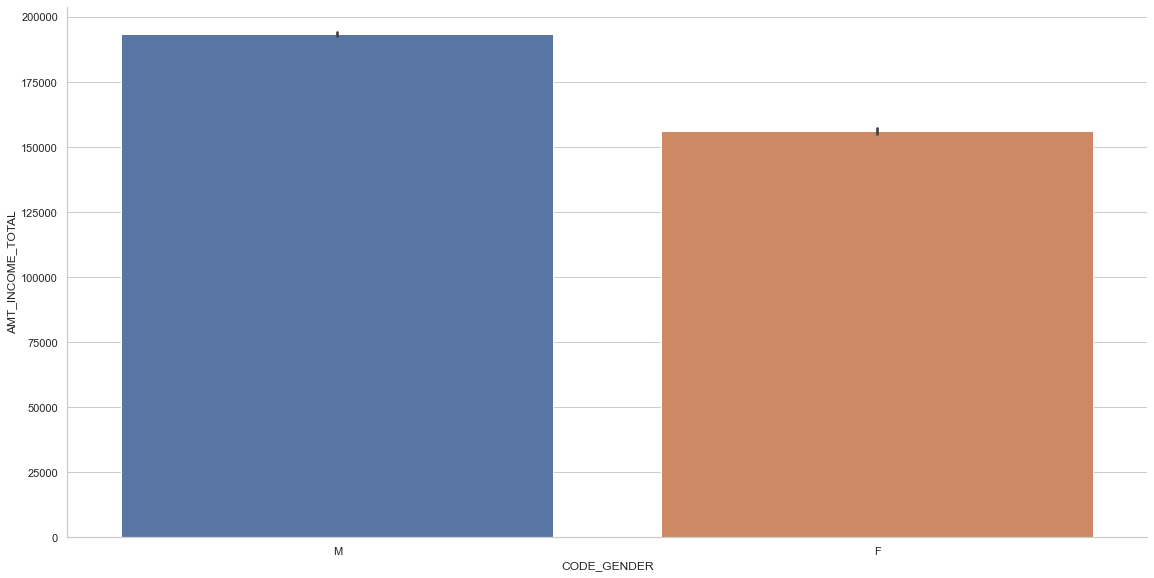

In [231]:

sns.catplot(x="CODE_GENDER", y="AMT_INCOME_TOTAL",kind="bar", height=8, aspect=2, data=appTrainC)


Le revenu des profils masculins est sensiblement plus important que les profils féminins

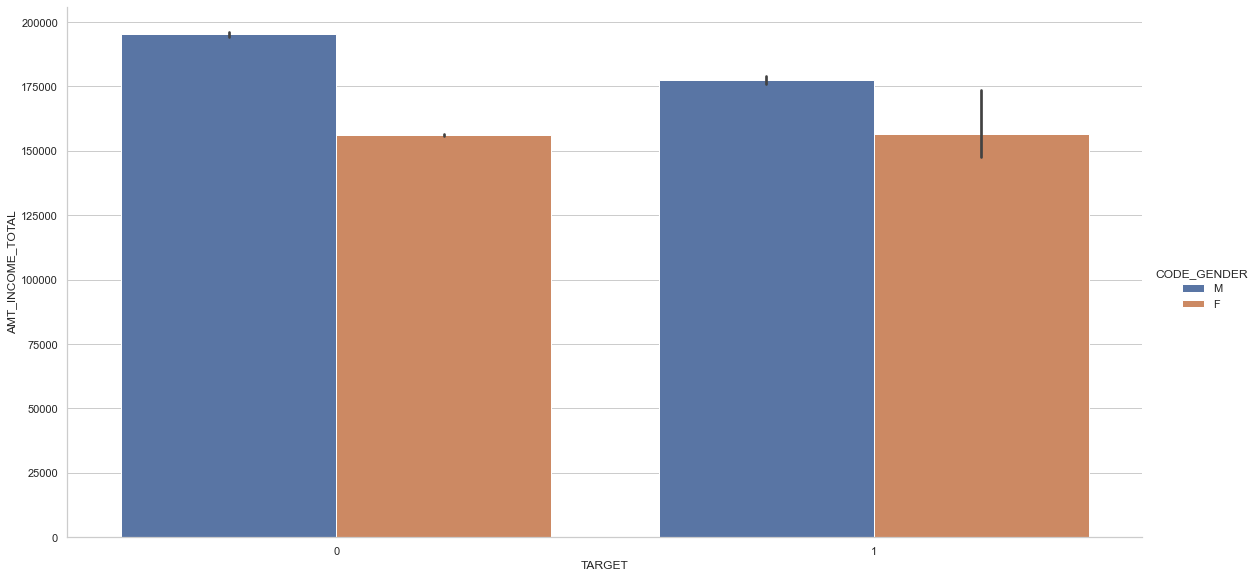

In [232]:
sns.catplot(x="TARGET", y="AMT_INCOME_TOTAL",kind="bar", hue="CODE_GENDER", height=8, aspect=2,data=appTrainC)

Les profils masculins en défaut de paiment gagnent en moyenne moins que les profils qui ne font pas de défaut de paiment. En revanche ce n'est pas le cas pour les profils féminins. Au contraire même. Les profils féminins en défaut de paiment ont des revenus légèrement supérieurs. <br>
Qu'est-ce qui implique alors le défaut de paiment si le salaire n'est pas un facteur important ?

In [233]:
appTrainC[appTrainC["TARGET"]==1]["CODE_GENDER"].value_counts()/appTrainC["CODE_GENDER"].value_counts()

F    0.069996
M    0.101423
Name: CODE_GENDER, dtype: float64

Les profils féminins sont certes plus important au sein du dataset, mais ramener à leur proportion, 7% des profils féminins font un défaut de paiment tandis que les profils masculins en défaut de paiment concernent 10%

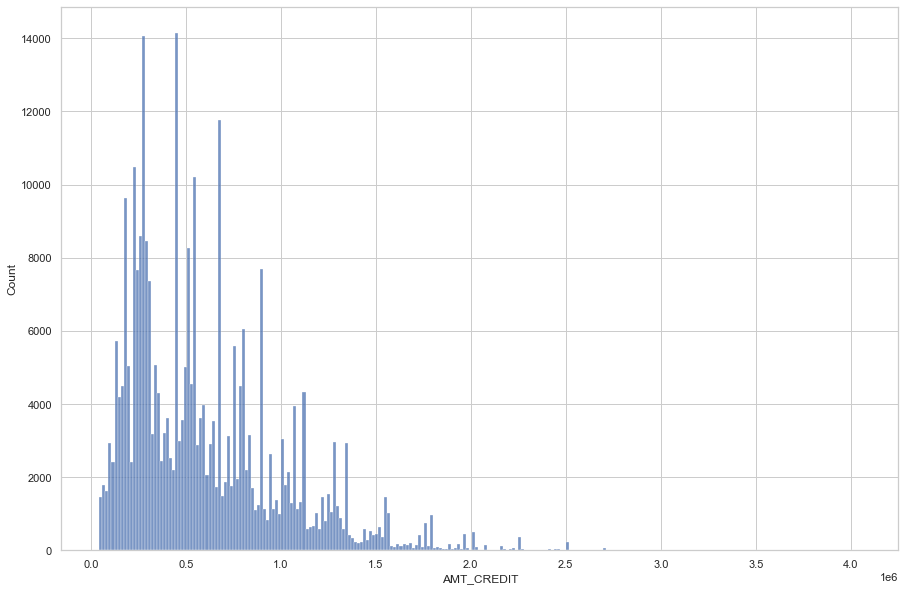

In [234]:
plt.figure(figsize=(15,10))
sns.histplot(data=appTrainC, x="AMT_CREDIT")
plt.show()

In [235]:
appTrainC["AMT_CREDIT"].mode()

0    450000.0
dtype: float32

Le mode des crédits est de 450000 (dollars)

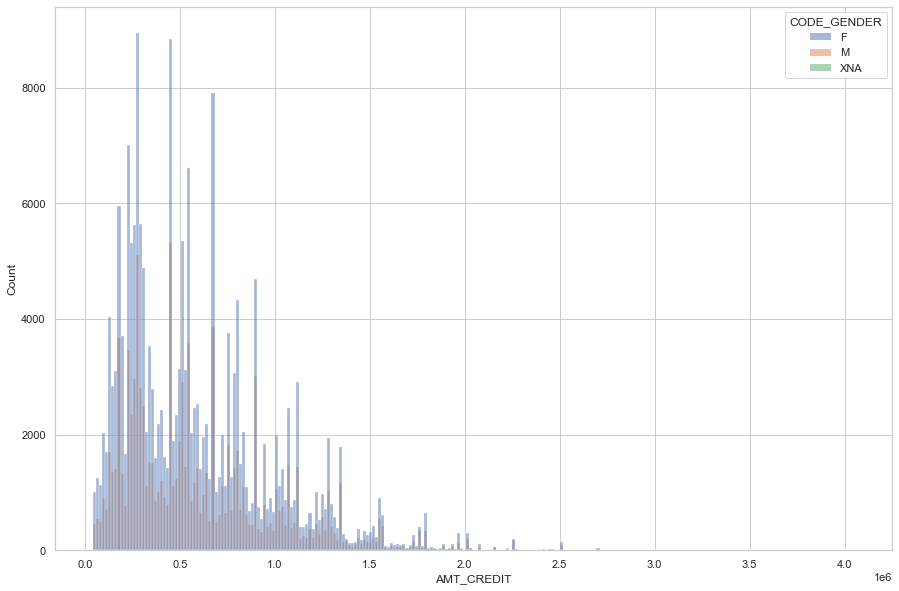

In [236]:
plt.figure(figsize=(15,10))
sns.histplot(data=appTrain, x="AMT_CREDIT", hue='CODE_GENDER')
plt.show()

Les F et M ont le même mode

In [237]:
print(pd.crosstab(appTrainC['NAME_CONTRACT_TYPE'], appTrainC['TARGET'], margins = True))

TARGET                   0      1     All
NAME_CONTRACT_TYPE                       
Cash loans          254999  23221  278220
Revolving loans      27671   1604   29275
All                 282670  24825  307495


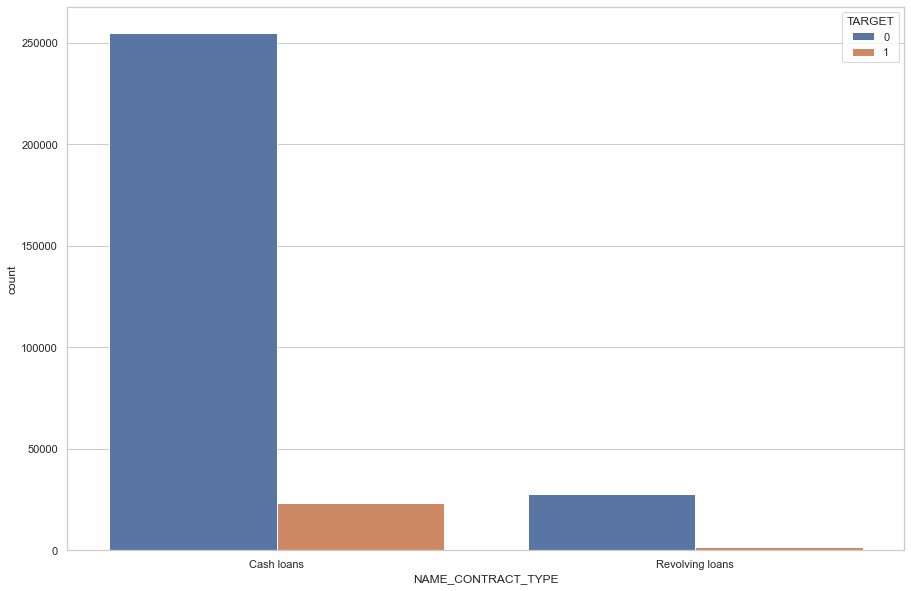

In [238]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x="NAME_CONTRACT_TYPE", hue="TARGET", data=appTrain)

In [239]:
pd.crosstab(appTrainC['NAME_CONTRACT_TYPE'], appTrainC['TARGET'], margins = True).loc["Cash loans"]

TARGET
0      254999
1       23221
All    278220
Name: Cash loans, dtype: int64

In [240]:
pd.crosstab(appTrainC['NAME_CONTRACT_TYPE'], appTrainC['TARGET'], margins = True).loc["Cash loans"]/278232

TARGET
0      0.916498
1      0.083459
All    0.999957
Name: Cash loans, dtype: float64

In [241]:
pd.crosstab(appTrainC['NAME_CONTRACT_TYPE'], appTrainC['TARGET'], margins = True).loc["Revolving loans"]

TARGET
0      27671
1       1604
All    29275
Name: Revolving loans, dtype: int64

In [242]:
pd.crosstab(appTrainC['NAME_CONTRACT_TYPE'], appTrainC['TARGET'], margins = True).loc["Revolving loans"]/29275

TARGET
0      0.945209
1      0.054791
All    1.000000
Name: Revolving loans, dtype: float64

Les contrats de type Cash Loans sont de très loin les plus demandés et c'est également sur ces types de contrat (en propotion) qu'il y a le plus de défaut de paiment.

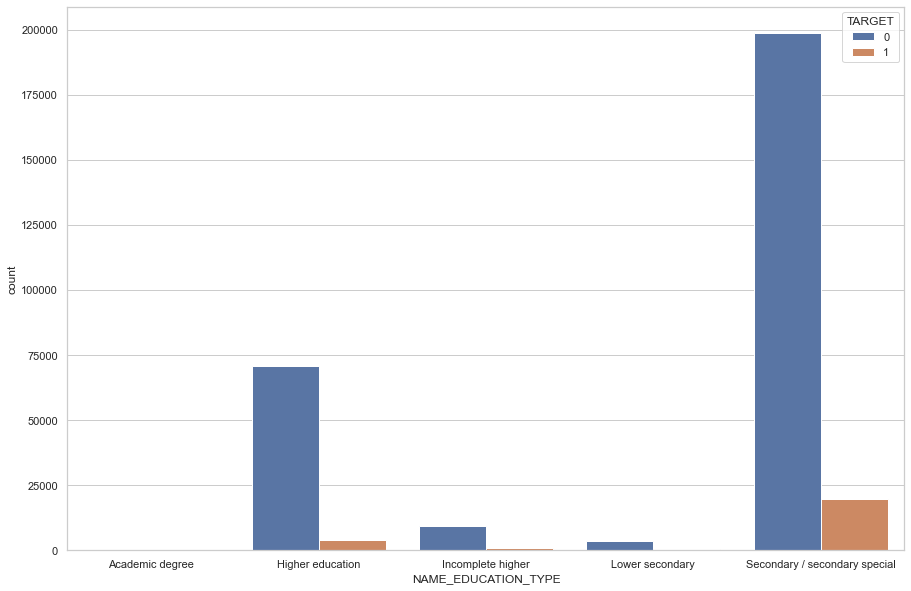

In [243]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x="NAME_EDUCATION_TYPE", hue="TARGET", data=appTrainC)

In [244]:
print(pd.crosstab(appTrain['NAME_EDUCATION_TYPE'], appTrain['TARGET'], margins = True))

TARGET                              0      1     All
NAME_EDUCATION_TYPE                                 
Academic degree                   161      3     164
Higher education                70854   4009   74863
Incomplete higher                9405    872   10277
Lower secondary                  3399    417    3816
Secondary / secondary special  198867  19524  218391
All                            282686  24825  307511


In [245]:
educ = pd.crosstab(appTrain['NAME_EDUCATION_TYPE'], appTrain['TARGET'], margins = True)

In [246]:
educ.iloc[0]/164

TARGET
0      0.981707
1      0.018293
All    1.000000
Name: Academic degree, dtype: float64

In [247]:
educ.iloc[1]/74863

TARGET
0      0.946449
1      0.053551
All    1.000000
Name: Higher education, dtype: float64

In [248]:
educ.iloc[2]/10277

TARGET
0      0.91515
1      0.08485
All    1.00000
Name: Incomplete higher, dtype: float64

In [249]:
educ.iloc[3]/3816

TARGET
0      0.890723
1      0.109277
All    1.000000
Name: Lower secondary, dtype: float64

In [250]:
educ.iloc[4]/218391

TARGET
0      0.910601
1      0.089399
All    1.000000
Name: Secondary / secondary special, dtype: float64

La classe __Lower secondary__ est plus susceptible d'avoir un défaut de paiment et les profils de la __Academic degree__ ont moins de defaut de paiment que les autres profils.

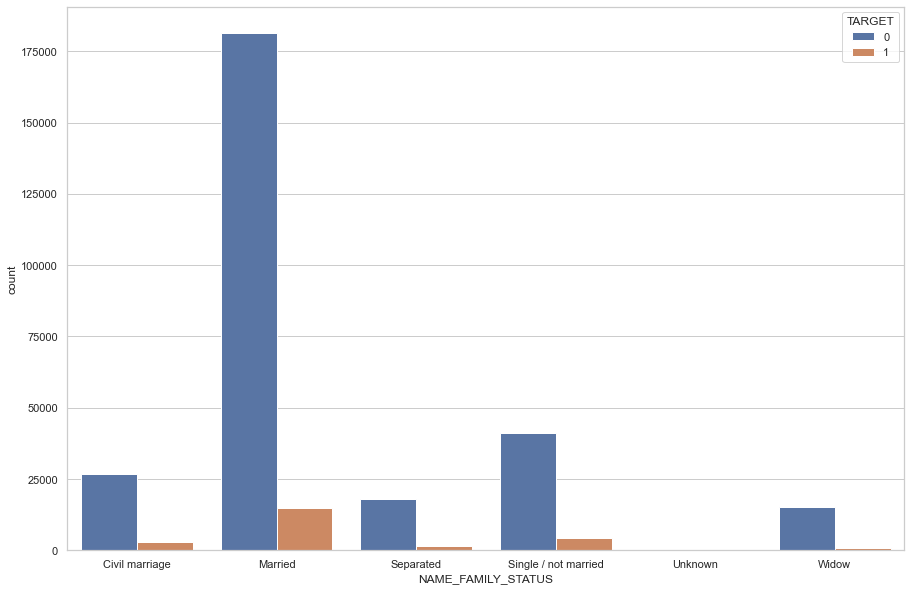

In [251]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x='NAME_FAMILY_STATUS', hue="TARGET", data=appTrainC)

In [252]:
familyStatus = pd.crosstab(appTrainC['NAME_FAMILY_STATUS'], appTrainC['TARGET'], margins = True)

In [253]:
familyStatus

TARGET,0,1,All
NAME_FAMILY_STATUS,,,
Civil marriage,26811,2961,29772
Married,181572,14850,196422
Separated,18150,1620,19770
Single / not married,40984,4457,45441
Unknown,2,0,2
Widow,15151,937,16088
All,282670,24825,307495


In [254]:
for i, ind in enumerate(familyStatus.index):
    print(ind)
    print(familyStatus.loc[ind]/familyStatus['All'].values[i])

Civil marriage
TARGET
0      0.900544
1      0.099456
All    1.000000
Name: Civil marriage, dtype: float64
Married
TARGET
0      0.924397
1      0.075603
All    1.000000
Name: Married, dtype: float64
Separated
TARGET
0      0.918058
1      0.081942
All    1.000000
Name: Separated, dtype: float64
Single / not married
TARGET
0      0.901917
1      0.098083
All    1.000000
Name: Single / not married, dtype: float64
Unknown
TARGET
0      1.0
1      0.0
All    1.0
Name: Unknown, dtype: float64
Widow
TARGET
0      0.941758
1      0.058242
All    1.000000
Name: Widow, dtype: float64
All
TARGET
0      0.919267
1      0.080733
All    1.000000
Name: All, dtype: float64


Les personnes seules sont plus susceptibles de faire un défaut.

In [255]:
appTrainC.groupby(by="TARGET")["REGION_POPULATION_RELATIVE"].mean()

TARGET
0    0.021027
1    0.019135
Name: REGION_POPULATION_RELATIVE, dtype: float16

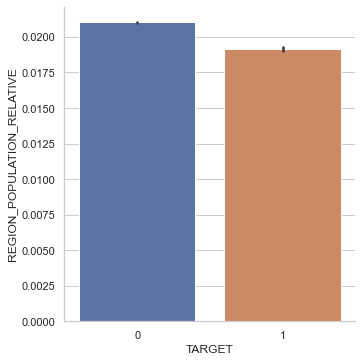

In [256]:
sns.catplot(x="TARGET", y="REGION_POPULATION_RELATIVE",kind="bar", data=appTrainC)

Les profils qui font défaut de paiment vivent dans des lieux moins peuplés.

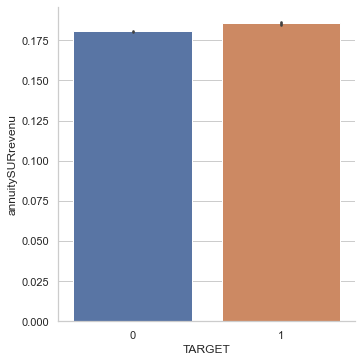

In [257]:
sns.catplot(x="TARGET", y="annuitySURrevenu",kind="bar", data=appTrainC)

Les mensualités pésent davantage sur les profils qui font défaut, mais ce n'est pas significatif.

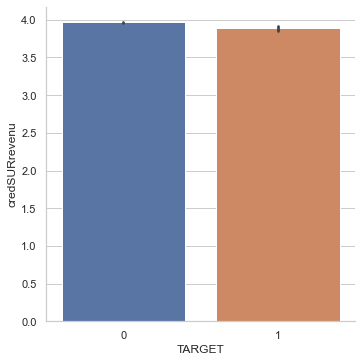

In [258]:
sns.catplot(x="TARGET", y="credSURrevenu",kind="bar", data=appTrainC)

Le poid du crédit sur le revenu total est plus ou moins équivalent sur les deux profils

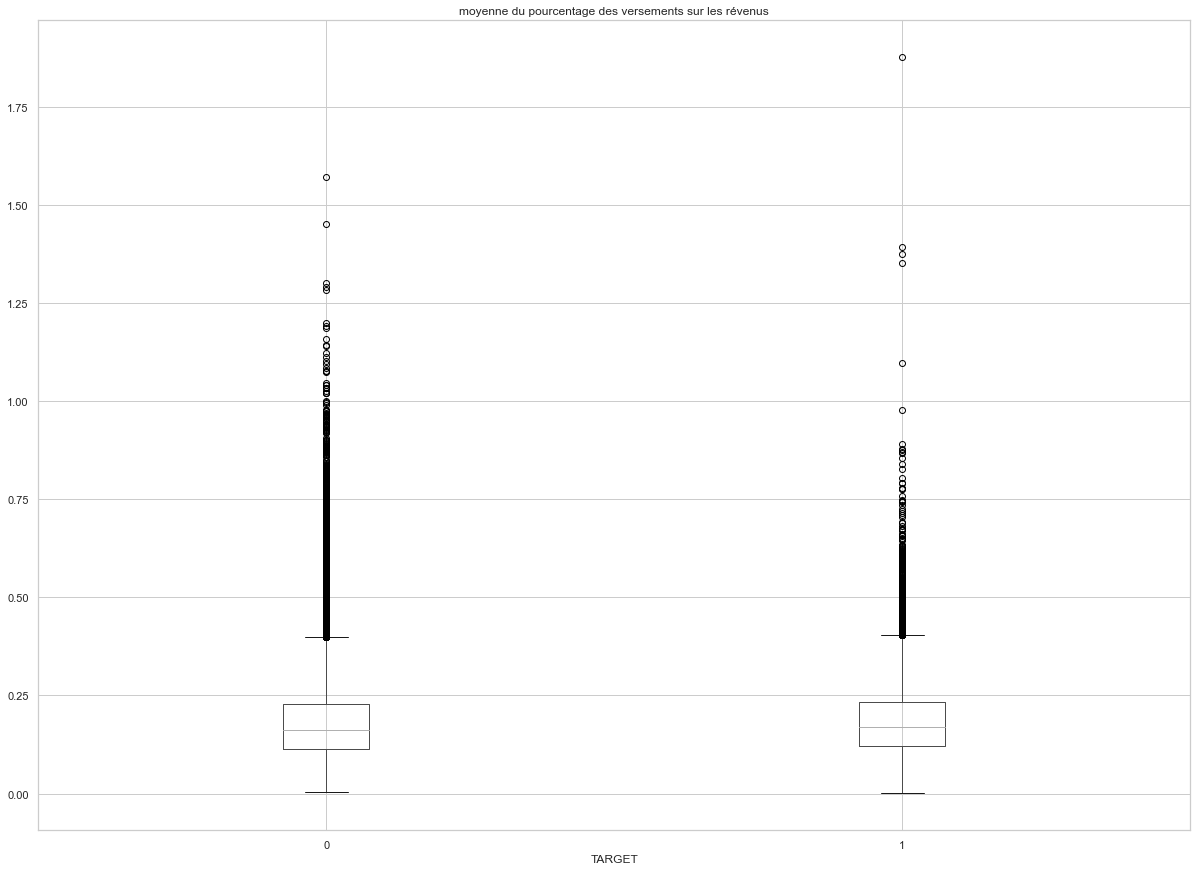

In [259]:
appTrainC.boxplot(column = ['annuitySURrevenu'], by = 'TARGET', figsize=(20,15))
plt.title('moyenne du pourcentage des versements sur les révenus')
plt.suptitle('')
plt.show()

Les deux profils (0 et 1) ont plus ou moins la même distribution avec un extremum chez 1, avec une mensualité qui pèse presque 2 fois ses revenus

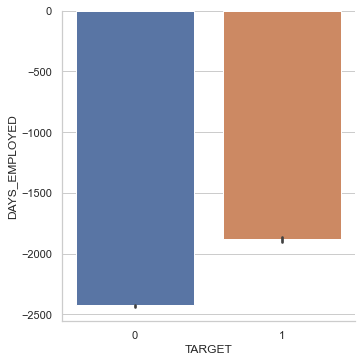

In [260]:
sns.catplot(x="TARGET", y="DAYS_EMPLOYED",kind="bar", data=appTrainC)

Nous constatons qu'il y a correlation entre le nombre de jour de salariat et le défaut de paiment.

In [261]:
appTrainC.groupby(by="TARGET")["CNT_FAM_MEMBERS"].mean()

TARGET
0    2.150391
1    2.181641
Name: CNT_FAM_MEMBERS, dtype: float16

<AxesSubplot:xlabel='TARGET'>

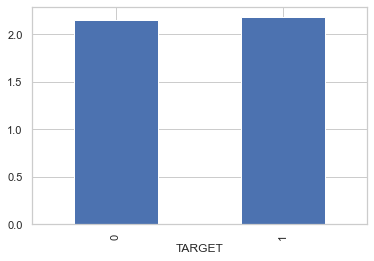

In [262]:
appTrainC.groupby(by="TARGET")["CNT_FAM_MEMBERS"].mean().plot.bar()

La taille des familles des deux profils est plus ou moins équivalente

In [263]:
house = pd.crosstab(appTrainC['NAME_HOUSING_TYPE'], appTrainC['TARGET'], margins = True)

In [264]:
house

TARGET,0,1,All
NAME_HOUSING_TYPE,,,
Co-op apartment,1033,89,1122
House / apartment,251583,21272,272855
Municipal apartment,10226,955,11181
Office apartment,2445,172,2617
Rented apartment,4279,601,4880
With parents,13104,1736,14840
All,282670,24825,307495


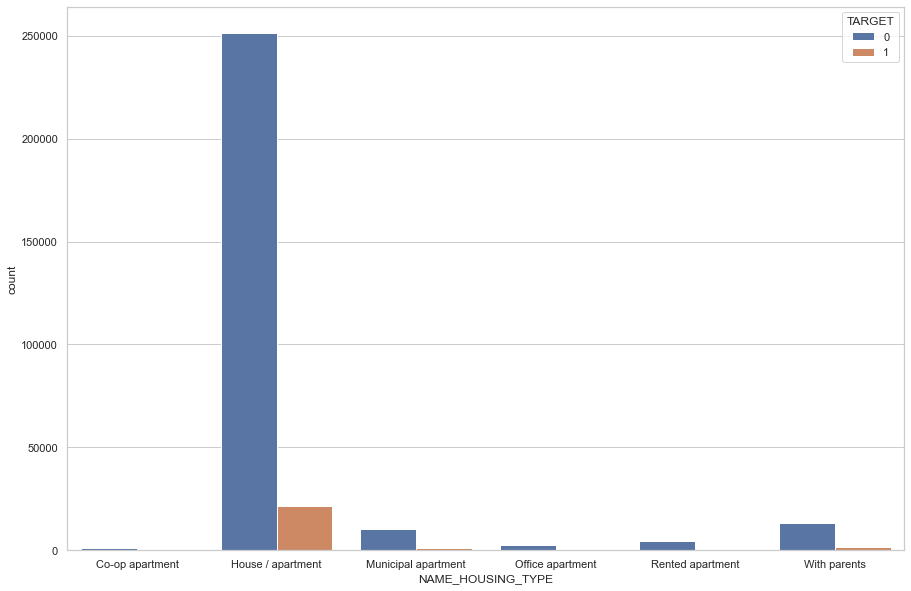

In [265]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x="NAME_HOUSING_TYPE", hue="TARGET", data=appTrainC)

In [266]:
for i, ind in enumerate(house.index):
    print(ind)
    print(house.loc[ind]/house['All'].values[i])

Co-op apartment
TARGET
0      0.920677
1      0.079323
All    1.000000
Name: Co-op apartment, dtype: float64
House / apartment
TARGET
0      0.922039
1      0.077961
All    1.000000
Name: House / apartment, dtype: float64
Municipal apartment
TARGET
0      0.914587
1      0.085413
All    1.000000
Name: Municipal apartment, dtype: float64
Office apartment
TARGET
0      0.934276
1      0.065724
All    1.000000
Name: Office apartment, dtype: float64
Rented apartment
TARGET
0      0.876844
1      0.123156
All    1.000000
Name: Rented apartment, dtype: float64
With parents
TARGET
0      0.883019
1      0.116981
All    1.000000
Name: With parents, dtype: float64
All
TARGET
0      0.919267
1      0.080733
All    1.000000
Name: All, dtype: float64


Les profils qui louent des appartements ont plus de chance de faire défaut.

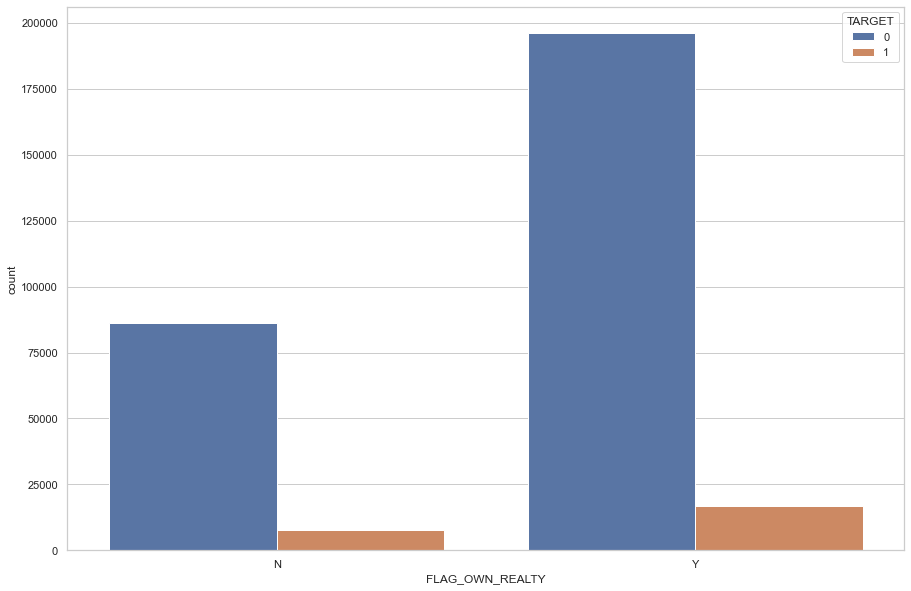

In [267]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x="FLAG_OWN_REALTY", hue="TARGET", data=appTrainC)

In [268]:
test = pd.crosstab(appTrainC["FLAG_OWN_REALTY"], appTrainC['TARGET'], margins = True)
test

TARGET,0,1,All
FLAG_OWN_REALTY,,,
N,86348,7842,94190
Y,196322,16983,213305
All,282670,24825,307495


In [269]:
for i, ind in enumerate(test.index):
    print(ind)
    print(test.loc[ind]/test['All'].values[i])

N
TARGET
0      0.916743
1      0.083257
All    1.000000
Name: N, dtype: float64
Y
TARGET
0      0.920382
1      0.079618
All    1.000000
Name: Y, dtype: float64
All
TARGET
0      0.919267
1      0.080733
All    1.000000
Name: All, dtype: float64


La possession d'un habitat n'influe pas sur le défaut

# Analyse bivariée

In [270]:
appTrainC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307495 entries, 0 to 307510
Data columns (total 50 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   SK_ID_CURR                  307495 non-null  int32   
 1   TARGET                      307495 non-null  int8    
 2   NAME_CONTRACT_TYPE          307495 non-null  category
 3   CODE_GENDER                 307495 non-null  object  
 4   FLAG_OWN_CAR                307495 non-null  category
 5   FLAG_OWN_REALTY             307495 non-null  category
 6   CNT_CHILDREN                307495 non-null  int8    
 7   AMT_INCOME_TOTAL            307495 non-null  float32 
 8   AMT_CREDIT                  307495 non-null  float32 
 9   AMT_ANNUITY                 307495 non-null  float32 
 10  AMT_GOODS_PRICE             307495 non-null  float32 
 11  NAME_INCOME_TYPE            307495 non-null  category
 12  NAME_EDUCATION_TYPE         307495 non-null  category
 13 

In [271]:
Description("FLAG_OWN_REALTY")

['Flag if client owns a house or flat']
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']


5    Flag if client owns a house or flat
Name: Description, dtype: category
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']

<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='AMT_CREDIT'>

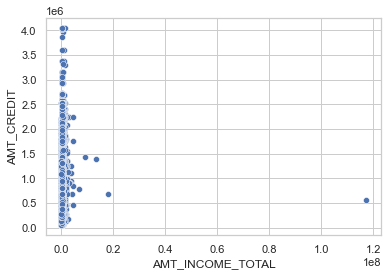

In [272]:
sns.scatterplot(x='AMT_INCOME_TOTAL', y = 'AMT_CREDIT', data=appTrainC)

La quantité de crédit n'a pas l'air d'être corrolé avec les revenus. Au contraire les hauts revenus demandent des crédits faibles.

<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='AMT_ANNUITY'>

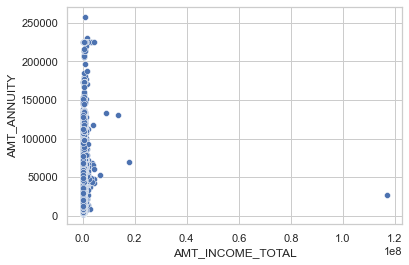

In [273]:
sns.scatterplot(x='AMT_INCOME_TOTAL', y = 'AMT_ANNUITY', data=appTrainC)

Les mensualités n'ont pas l'air d'être corrolé avec les revenus.

In [274]:
sns.scatterplot(x='EXT_SOURCE_2', y = 'AMT_ANNUITY', data=appTrainC)

<AxesSubplot:xlabel='EXT_SOURCE_2', ylabel='AMT_ANNUITY'>

Error in callback <function flush_figures at 0x7f326ef4ad30> (for post_execute):


KeyboardInterrupt: 

<AxesSubplot:xlabel='EXT_SOURCE_3', ylabel='AMT_ANNUITY'>

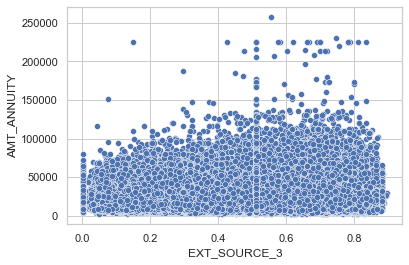

In [275]:
sns.scatterplot(x='EXT_SOURCE_3', y = 'AMT_ANNUITY', data=appTrainC)

<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='REGION_POPULATION_RELATIVE'>

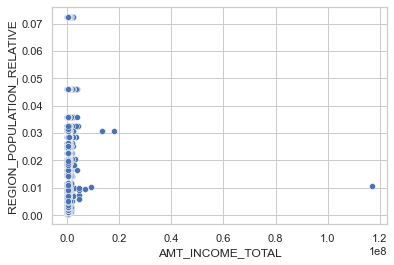

In [276]:
sns.scatterplot(x='AMT_INCOME_TOTAL', y = 'REGION_POPULATION_RELATIVE', data=appTrainC)

# Corrélation

In [277]:
# bureau

In [278]:
# homeCredit

In [279]:
# previous_Apps

In [280]:
correlation = appTrainC.drop(['SK_ID_CURR', 'TARGET'], axis=1)

In [281]:
correlation = correlation.select_dtypes(exclude=['object', 'category', 'int8'])

In [282]:
correlation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307495 entries, 0 to 307510
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AMT_INCOME_TOTAL            307495 non-null  float32
 1   AMT_CREDIT                  307495 non-null  float32
 2   AMT_ANNUITY                 307495 non-null  float32
 3   AMT_GOODS_PRICE             307495 non-null  float32
 4   REGION_POPULATION_RELATIVE  307495 non-null  float16
 5   DAYS_BIRTH                  307495 non-null  int16  
 6   DAYS_EMPLOYED               307495 non-null  float64
 7   CNT_FAM_MEMBERS             307495 non-null  float16
 8   EXT_SOURCE_2                307495 non-null  float16
 9   EXT_SOURCE_3                307495 non-null  float16
 10  credSURrevenu               307495 non-null  float32
 11  annuitySURrevenu            307495 non-null  float32
dtypes: float16(4), float32(6), float64(1), int16(1)
memory usage: 22.7 MB


<AxesSubplot:>

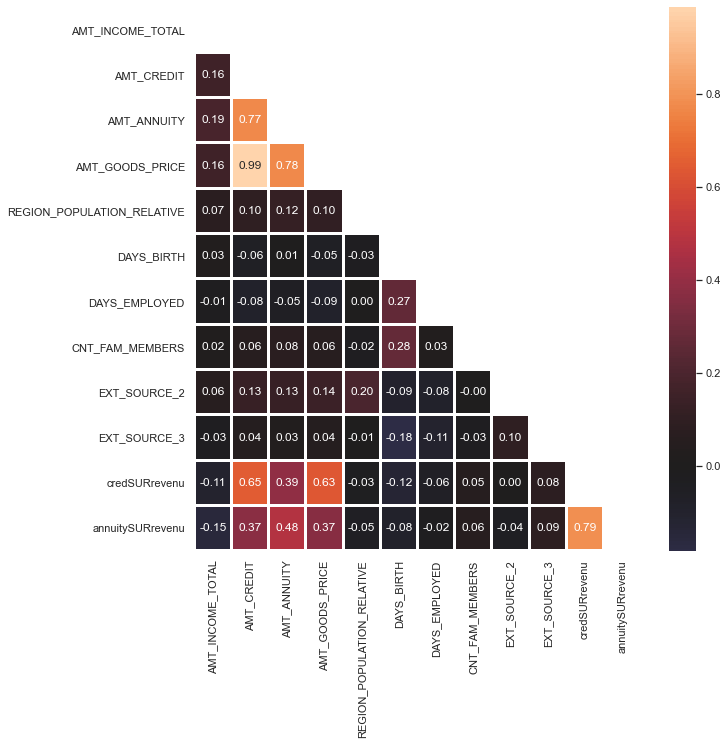

In [283]:
corr = correlation.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10,10))
sns.heatmap(corr, center=0, linewidths=2, mask=mask, annot=True, fmt=".2f")

AMT_GOODS_PRICE et AMT_CREDIT sont très fortement corrolés. Nous supprimerons l'un des deux par la suite.

In [284]:
#appTrainC.to_csv('app/Train.csv', index=False)

# Aggregation des données

## Bureau

In [285]:
# bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
# bureau_agg.head()

In [539]:
modelisation = bureau.drop(['SK_ID_CURR', 'SK_ID_BUREAU'], axis=1)
model_num = modelisation.select_dtypes(exclude=['object', 'category'])
model_cat = modelisation.select_dtypes(include=['object', 'category'])
model_onhot = pd.get_dummies(model_cat, drop_first=True)
bureau_agg = pd.concat([bureau["SK_ID_CURR"],model_num, model_onhot], axis=1)
bureau_agg = bureau_agg.groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()


In [540]:
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                                 CREDIT_DAY_OVERDUE  \
                   count         mean  max   min     sum              count   
0     100001           7  -735.000000  -49 -1572 -5145.0                  7   
1     100002           8  -874.000000 -103 -1437 -6992.0                  8   
2     100003           4 -1400.750000 -606 -2586 -5603.0                  4   
3     100004           2  -867.000000 -408 -1326 -1734.0                  2   
4     100005           3  -190.666667  -62  -373  -572.0                  3   

                ... CREDIT_TYPE_Real estate loan                   \
  mean max min  ...                        count mean max min sum   
0  0.0   0   0  ...                            7  0.0   0   0   0   
1  0.0   0   0  ...                            8  0.0   0   0   0   
2  0.0   0   0  ...                            4  0.0   0   0   0   
3  0.0   0   0  ...                            2  0.0   0   0   0   
4  0.0   0   0  ...                            3  0.0   0   0   0   

  CREDIT_TYPE_Unknown type of loan                   
                             count mean max min sum  
0                                7  0.0   0   0   0  
1                                8  0.0   0   0   0  
2                                4  0.0   0   0   0  
3                                2  0.0   0   0   0  
4                                3  0.0   0   0   0  

[5 rows x 161 columns]

Nous agrégeons les données selon 5 modalités statistiques 'count', 'mean', 'max', 'min', 'sum'

In [541]:


columns = ['SK_ID_CURR']

for var in bureau_agg.columns.levels[0]:
    if var != 'SK_ID_CURR':
        
        for stat in bureau_agg.columns.levels[1][:-1]:
        
            columns.append('bureau_%s_%s' % (var, stat))
            
bureau_agg.columns = columns
bureau_agg.head()



,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_mean,bureau_CREDIT_TYPE_Real estate loan_max,bureau_CREDIT_TYPE_Real estate loan_min,bureau_CREDIT_TYPE_Real estate loan_sum,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_mean,bureau_CREDIT_TYPE_Unknown type of loan_max,bureau_CREDIT_TYPE_Unknown type of loan_min,bureau_CREDIT_TYPE_Unknown type of loan_sum
0,100001,7,-735.000000,-49,-1572,-5145.0,7,0.0,0,0,...,7,0.0,0,0,0,7,0.0,0,0,0
1,100002,8,-874.000000,-103,-1437,-6992.0,8,0.0,0,0,...,8,0.0,0,0,0,8,0.0,0,0,0
2,100003,4,-1400.750000,-606,-2586,-5603.0,4,0.0,0,0,...,4,0.0,0,0,0,4,0.0,0,0,0
3,100004,2,-867.000000,-408,-1326,-1734.0,2,0.0,0,0,...,2,0.0,0,0,0,2,0.0,0,0,0
4,100005,3,-190.666667,-62,-373,-572.0,3,0.0,0,0,...,3,0.0,0,0,0,3,0.0,0,0,0


Nous avons renommé les colonnes

In [288]:
#  bureau

In [289]:
# bureau["CREDIT_ACTIVE"].unique()

In [290]:
# bureau["CREDIT_ACTIVE"].value_counts()

## Créations de nouveaux features à bureau_agg

In [291]:
# bureau.loc[bureau['SK_ID_CURR']==215354]

In [292]:
# active = ['Closed','Active','Sold', 'Bad debt']

In [293]:
# Active = dict.fromkeys(active,0)

In [294]:
# Active

In [295]:
# bureau.loc[bureau['SK_ID_CURR']==215354]['CREDIT_ACTIVE'].value_counts()[active].values

In [296]:
# bureau_agg[active]=0

In [297]:
# bureau_agg

In [298]:
# count = 0
# for i in bureau_agg["SK_ID_CURR"]:
#     bureau_agg.loc[bureau_agg["SK_ID_CURR"]==i, active]=bureau.loc[bureau['SK_ID_CURR']==i]['CREDIT_ACTIVE'].value_counts()[active].values
#     if count%1000 == 0:
#         print(count)
#     count +=1

In [299]:
# bureau_agg.head()

Nous avons créé de nouvelles features, soient Closed, Active, Sold, Bad debt qui comptent l'état des crédits du client

In [300]:
# bureau_agg.to_csv('bureau_agg.csv', index=False)
#bureau_agg = pd.read_csv('bureau_agg.csv')

sauvegarde des données sur le disque

In [301]:
appTrainC = appTrainC.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

In [302]:
appTrainC

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,credSURrevenu,annuitySURrevenu,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum,Closed,Active,Sold,Bad debt
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637.000000,1,1,0,1,1,0,1.0,Business Entity Type 3,0.262939,0.139404,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.007889,0.121978,8.0,-874.000000,-103.0,-1437.0,-6992.0,8.0,0.0,0.0,0.0,0.0,6.0,-349.0,780.0,-1072.0,-2094.0,6.0,-697.5,-36.0,-1185.0,-4184.0,5.0,1681.029,5043.645,0.0,8405.145,8.0,0.000000,0.0,0.0,0.0,8.0,108131.945,450000.0,0.0,865055.56,5.0,49156.20,245781.0,0.0,245781.0,4.0,7997.141,31988.564,0.0,31988.564,8.0,0.0,0.0,0.0,0.0,8.0,-499.875000,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0,6.0,2.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188.000000,1,1,0,1,1,0,2.0,School,0.622070,0.510742,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.790750,0.132217,4.0,-1400.750000,-606.0,-2586.0,-5603.0,4.0,0.0,0.0,0.0,0.0,4.0,-544.5,1216.0,-2434.0,-2178.0,3.0,-1098.0,-540.0,-2132.0,-3292.0,4.0,0.000,0.000,0.0,0.000,4.0,0.000000,0.0,0.0,0.0,4.0,254350.120,810000.0,22248.0,1017400.50,4.0,0.00,0.0,0.0,0.0,4.0,202500.000,810000.000,0.0,810000.000,4.0,0.0,0.0,0.0,0.0,4.0,-816.000000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0,3.0,1.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Working,Secondary / se

# Autre aggregat

In [ ]:

# appTrain = reduce_mem_usage(appTrain)
# bureau = reduce_mem_usage(bureau) 
# bureauBal = reduce_mem_usage(bureauBal) 
# creditCardBal = reduce_mem_usage(creditCardBal) 
# homeCredit = reduce_mem_usage(homeCredit) 
# installmentsP = reduce_mem_usage(installmentsP) 
# POS_CASH_B = reduce_mem_usage(POS_CASH_B) 
# previous_Apps = reduce_mem_usage(previous_Apps) 
# sample_sub = reduce_mem_usage(sample_sub) 

In [429]:
creditCardBal.shape

(3840312, 23)

In [430]:
creditCardBal
modelisation = creditCardBal.drop(['SK_ID_CURR', 'SK_ID_PREV'], axis=1)
model_num = modelisation.select_dtypes(exclude=['object', 'category'])
model_cat = modelisation.select_dtypes(include=['object', 'category'])
model_onhot = pd.get_dummies(model_cat, drop_first=True)
creditCardBal_agg = pd.concat([creditCardBal["SK_ID_CURR"],model_num, model_onhot], axis=1)

In [431]:
creditCardBal_agg = creditCardBal_agg.groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
creditCardBal_agg.head()

SK_ID_CURR MONTHS_BALANCE                       AMT_BALANCE                \
                      count  mean max min     sum       count          mean   
0     100006              6  -3.5  -1  -6   -21.0           6      0.000000   
1     100011             74 -38.5  -2 -75 -2849.0          74  54482.109375   
2     100013             96 -48.5  -1 -96 -4656.0          96  18159.919922   
3     100021             17 -10.0  -2 -18  -170.0          17      0.000000   
4     100023              8  -7.5  -4 -11   -60.0           8      0.000000   

                      ... NAME_CONTRACT_STATUS_Sent proposal                   \
            max  min  ...                              count mean max min sum   
0       0.00000  0.0  ...                                  6  0.0   0   0   0   
1  189000.00000  0.0  ...                                 74  0.0   0   0   0   
2  161420.21875  0.0  ...                                 96  0.0   0   0   0   
3       0.00000  0.0  ...                                 17  0.0   0   0   0   
4       0.00000  0.0  ...                                  8  0.0   0   0   0   

  NAME_CONTRACT_STATUS_Signed                   
                        count mean max min sum  
0                           6  0.0   0   0   0  
1                          74  0.0   0   0   0  
2                          96  0.0   0   0   0  
3                          17  0.0   0   0   0  
4                           8  0.0   0   0   0  

[5 rows x 131 columns]

In [ ]:
def aggregation(drop = [], groupby='', data):
    modelisation = data.drop(drop, axis=1)
    model_num = modelisation.select_dtypes(exclude=['object', 'category'])
    model_cat = modelisation.select_dtypes(include=['object', 'category'])
    model_onhot = pd.get_dummies(model_cat, drop_first=True)
    data_agg = pd.concat([data[groupby],model_num, model_onhot], axis=1)
    data_agg = data_agg.groupby(groupby, as_index = False).agg(['count', 'mean', 'median' 'max', 'min', 'sum']).reset_index()
    
    return data_agg
    

In [432]:

columns = ['SK_ID_CURR']

for var in creditCardBal_agg.columns.levels[0]:
    if var != 'SK_ID_CURR':
        
        for stat in creditCardBal_agg.columns.levels[1][:-1]:
        
            columns.append('bureau_%s_%s' % (var, stat))
            
creditCardBal_agg.columns = columns
creditCardBal_agg.head()

,SK_ID_CURR,bureau_MONTHS_BALANCE_count,bureau_MONTHS_BALANCE_mean,bureau_MONTHS_BALANCE_max,bureau_MONTHS_BALANCE_min,bureau_MONTHS_BALANCE_sum,bureau_AMT_BALANCE_count,bureau_AMT_BALANCE_mean,bureau_AMT_BALANCE_max,bureau_AMT_BALANCE_min,...,bureau_NAME_CONTRACT_STATUS_Sent proposal_count,bureau_NAME_CONTRACT_STATUS_Sent proposal_mean,bureau_NAME_CONTRACT_STATUS_Sent proposal_max,bureau_NAME_CONTRACT_STATUS_Sent proposal_min,bureau_NAME_CONTRACT_STATUS_Sent proposal_sum,bureau_NAME_CONTRACT_STATUS_Signed_count,bureau_NAME_CONTRACT_STATUS_Signed_mean,bureau_NAME_CONTRACT_STATUS_Signed_max,bureau_NAME_CONTRACT_STATUS_Signed_min,bureau_NAME_CONTRACT_STATUS_Signed_sum
0,100006,6,-3.5,-1,-6,-21.0,6,0.000000,0.00000,0.0,...,6,0.0,0,0,0,6,0.0,0,0,0
1,100011,74,-38.5,-2,-75,-2849.0,74,54482.109375,189000.00000,0.0,...,74,0.0,0,0,0,74,0.0,0,0,0
2,100013,96,-48.5,-1,-96,-4656.0,96,18159.919922,161420.21875,0.0,...,96,0.0,0,0,0,96,0.0,0,0,0
3,100021,17,-10.0,-2,-18,-170.0,17,0.000000,0.00000,0.0,...,17,0.0,0,0,0,17,0.0,0,0,0
4,100023,8,-7.5,-4,-11,-60.0,8,0.000000,0.00000,0.0,...,8,0.0,0,0,0,8,0.0,0,0,0


In [433]:
appTrainC = appTrainC.merge(creditCardBal_agg, on = 'SK_ID_CURR', how = 'left')

In [434]:
appTrainC

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_NAME_CONTRACT_STATUS_Sent proposal_count,bureau_NAME_CONTRACT_STATUS_Sent proposal_mean,bureau_NAME_CONTRACT_STATUS_Sent proposal_max,bureau_NAME_CONTRACT_STATUS_Sent proposal_min,bureau_NAME_CONTRACT_STATUS_Sent proposal_sum,bureau_NAME_CONTRACT_STATUS_Signed_count,bureau_NAME_CONTRACT_STATUS_Signed_mean,bureau_NAME_CONTRACT_STATUS_Signed_max,bureau_NAME_CONTRACT_STATUS_Signed_min,bureau_NAME_CONTRACT_STATUS_Signed_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,6.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307490,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307491,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307492,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307493,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [496]:
supprimer = extraireColonneInf(appTrainC,0.7)

In [497]:
appTrainC.drop(supprimer, axis=1, inplace=True)

In [498]:
appTrainC

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_sum,Closed,Active,Sold,Bad debt
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-499.875000,-7.0,-1185.0,-3999.0,7.0,0.0,6.0,2.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,-816.000000,-43.0,-2131.0,-3264.0,0.0,0.0,3.0,1.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,-532.000000,-382.0,-682.0,-1064.0,0.0,0.0,2.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,-783.000000,-783.0,-783.0,-783.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307490,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307491,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307492,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,-253.250000,-5.0,-701.0,-1013.0,3.0,175108.5,2.0,2.0,0.0,0.0
307493,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,-401.000000,-401.0,-401.0,-401.0,1.0,0.0,1.0,0.0,0.0,0.0


In [422]:
previous_Apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype   
---  ------                       --------------    -----   
 0   SK_ID_PREV                   1670214 non-null  int32   
 1   SK_ID_CURR                   1670214 non-null  int32   
 2   NAME_CONTRACT_TYPE           1670214 non-null  category
 3   AMT_ANNUITY                  1297979 non-null  float32 
 4   AMT_APPLICATION              1670214 non-null  float32 
 5   AMT_CREDIT                   1670213 non-null  float32 
 6   AMT_DOWN_PAYMENT             774370 non-null   float32 
 7   AMT_GOODS_PRICE              1284699 non-null  float32 
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  category
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int8    
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  category
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int8    
 12  RATE_DOWN_PAYMENT           

In [424]:
installmentsP

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500000,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500000,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.433594,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500000,NaN


# Modélisation (Classification)

In [499]:
modelisation = appTrainC.drop(['SK_ID_CURR', 'TARGET', 'AMT_GOODS_PRICE'], axis=1)

In [500]:
#modelisation

In [501]:
model_num = modelisation.select_dtypes(exclude=['object', 'category'])
model_cat = modelisation.select_dtypes(include=['object', 'category'])

Nous segmentons les données en deux : les features numériques et les features catégorielles

In [502]:
# model_cat

In [503]:
# modelisation.info()

In [504]:
# modelisation['DAYS_EMPLOYED'].min()

In [505]:
model_onhot = pd.get_dummies(model_cat, drop_first=True)

In [506]:
model_onhot.shape

(307495, 82)

Nous encodons les valeurs catégorielles en valeur numérique

In [507]:
model = pd.concat([model_num, model_onhot], axis=1)

In [508]:
model

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,0,202500.0,406597.5,24700.5,0.018799,-9461,-637.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,270000.0,1293502.5,35698.5,0.003542,-16765,-1188.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,67500.0,135000.0,6750.0,0.010033,-19046,-225.000000,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,135000.0,312682.5,29686.5,0.008018,-19005,-3039.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,121500.0,513000.0,21865.5,0.028656,-19932,-3038.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307490,0,157500.0,254700.0,27558.0,0.032562,-9327,-236.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,0
307491,0,72000.0,269550.0,12001.5,0.025162,-20775,-2384.175794,1,0,0,...,0,0,0,0,0,0,0,0,0,1
307492,0,153000.0,677664.0,29979.0,0.005001,-14966,-7921.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,0
307493,0,171000.0,370107.0,20205.0,0.005314,-11961,-4786.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,0


## Pycaret

In [509]:
modelS = pd.concat([model, appTrainC['TARGET']], axis=1)

In [510]:
modelS

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,...,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,TARGET
0,0,202500.0,406597.5,24700.5,0.018799,-9461,-637.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,270000.0,1293502.5,35698.5,0.003542,-16765,-1188.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,67500.0,135000.0,6750.0,0.010033,-19046,-225.000000,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,135000.0,312682.5,29686.5,0.008018,-19005,-3039.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,121500.0,513000.0,21865.5,0.028656,-19932,-3038.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307490,0,157500.0,254700.0,27558.0,0.032562,-9327,-236.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,0
307491,0,72000.0,269550.0,12001.5,0.025162,-20775,-2384.175794,1,0,0,...,0,0,0,0,0,0,0,0,1,0
307492,0,153000.0,677664.0,29979.0,0.005001,-14966,-7921.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,0
307493,0,171000.0,370107.0,20205.0,0.005314,-11961,-4786.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [511]:
clf1 = setup(data = modelS, target = 'TARGET')

,Description,Value
0,session_id,2564
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(307495, 179)"
5,Missing Values,True
6,Numeric Features,173
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
#best_model = compare_models(sort = 'AUC')

Selon les modèles, nous pouvons maximiser différents scores. Mais il n'existe pas un modèle qui maximise le recall et la precision.

In [ ]:
ensembled_models = compare_models(models(type='ensemble').index.tolist(), fold = 3, sort = 'AUC')

## Recentrons les données

Nous allons réutiliser les mêmes algorithmes mais cette fois sur des données recentrées

In [ ]:
# scaler = StandardScaler()
# scaler.fit(model_num)
# model_scale = scaler.transform(model_num)

In [ ]:
# model = pd.concat([pd.DataFrame(model_scale).reset_index(), model_onhot.reset_index()], axis=1)

In [ ]:
# model_scale.shape

In [ ]:
# model_onhot.shape

In [ ]:
# model

In [ ]:
# model.drop(['index'], axis=1, inplace=True)

In [ ]:
# model.shape

In [ ]:
# modelS = pd.concat([model, appTrainC['TARGET']], axis=1)

In [ ]:
# clf1 = setup(data = modelS, target = 'TARGET')

In [ ]:
# best_model = compare_models()

## resamplons les datas

In [512]:
count_nondefault, count_default = modelS['TARGET'].value_counts()

In [513]:
count_default

24825

In [514]:
count_nondefault

282670

In [515]:
nondefaults = modelS[modelS['TARGET'] == 0]
defaults = modelS[modelS['TARGET'] == 1]

In [516]:
nondefaults_under = nondefaults.sample(count_default)

In [517]:
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

In [518]:
clf1 = setup(data = X_y_train_under, target = 'TARGET')

,Description,Value
0,session_id,341
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(49650, 179)"
5,Missing Values,True
6,Numeric Features,173
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


In [519]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6812,0.7458,0.6813,0.6821,0.6817,0.3624,0.3625,1.1280
gbc,Gradient Boosting Classifier,0.6785,0.7434,0.6812,0.6785,0.6798,0.3570,0.3570,8.3820
lda,Linear Discriminant Analysis,0.6772,0.7409,0.6766,0.6783,0.6774,0.3544,0.3544,0.8230
ridge,Ridge Classifier,0.6770,0.0000,0.6765,0.6782,0.6773,0.3540,0.3541,0.0650
ada,Ada Boost Classifier,0.6739,0.7355,0.6708,0.6760,0.6733,0.3478,0.3479,1.6450
xgboost,Extreme Gradient Boosting,0.6710,0.7318,0.6703,0.6722,0.6712,0.3421,0.3421,18.4060
rf,Random Forest Classifier,0.6688,0.7272,0.6515,0.6758,0.6634,0.3377,0.3379,2.7610
et,Extra Trees Classifier,0.6609,0.7178,0.6521,0.6648,0.6584,0.3219,0.3220,3.0540
lr,Logistic Regression,0.5875,0.6223,0.5216,0.6019,0.5588,0.1752,0.1768,9.4810
dt,Decision Tree Classifier,0.5862,0.5862,0.5895,0.5867,0.5881,0.1725,0.1725,0.5390


In [ ]:
ensembled_models = compare_models(models(type='ensemble').index.tolist(), fold = 10)

L'algorithme __lightgbm__ est un bon compromis entre les scores Accuracy, AUC, Recall, Prec

# Light Gradient Boosting Machine

In [520]:
modelisation = appTrainC.drop(['SK_ID_CURR', 'TARGET', 'AMT_GOODS_PRICE'], axis=1)

In [521]:
model_num = modelisation.select_dtypes(exclude=['object', 'category'])
model_cat = modelisation.select_dtypes(include=['object', 'category'])

In [522]:
model_onhot = pd.get_dummies(model_cat, drop_first=True)

In [523]:
model = pd.concat([model_num, model_onhot], axis=1)

In [524]:
X = model
y = appTrainC['TARGET']

In [525]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

Nous divisons les données en deux. Un training set et test set

In [441]:
lgbm = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 42)

In [442]:
#display(X_train)

In [443]:
clf = lgbm.fit(X_train.to_numpy(), y_train)

In [444]:
preds = clf.predict(X_test)

In [445]:
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.93      0.94      0.94     56534
     Default       0.26      0.23      0.25      4965

    accuracy                           0.88     61499
   macro avg       0.59      0.59      0.59     61499
weighted avg       0.88      0.88      0.88     61499



In [446]:
print(metrics.roc_auc_score(y_test, preds))

0.5875195940337449


# Resamplons les données

In [526]:
X_y_train = pd.concat([X_train.reset_index(drop = True), y_train.reset_index(drop = True)], axis = 1)

In [527]:
count_nondefault, count_default = X_y_train['TARGET'].value_counts()

In [528]:
nondefaults = X_y_train[X_y_train['TARGET'] == 0]
defaults = X_y_train[X_y_train['TARGET'] == 1]

In [529]:
nondefaults_under = nondefaults.sample(count_default)

In [530]:
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

In [531]:
print(X_y_train_under['TARGET'].value_counts())

0    19860
1    19860
Name: TARGET, dtype: int64


In [532]:
X = X_y_train_under.drop('TARGET', axis=1)
y = X_y_train_under['TARGET']

In [533]:
clfL = lgb.LGBMClassifier(n_jobs = -1, random_state = 42).fit(X.to_numpy(), y)

In [534]:
# clfL = lgb.LGBMClassifier()
# rfe = RFE(clfL, 3)
# fit = rfe.fit(X.to_numpy(), y)
# print("Num Features: %d" % fit.n_features_)
# print("Selected Features: %s" % fit.support_)
# print("Feature Ranking: %s" % fit.ranking_)

In [535]:
#X.loc[:,fit.support_].to_numpy()

In [536]:
# roc = 0
# ind = 0
# col = len(X.columns)
# for i in range(2,col):
#     clfL = lgb.LGBMClassifier(n_jobs = -1, random_state = 42)
#     rfe = RFE(clfL, i)
#     fit = rfe.fit(X.to_numpy(), y)
#     clfL = lgb.LGBMClassifier(n_jobs = -1, random_state = 42).fit(X.loc[:,fit.support_].to_numpy(), y)
#     preds = clfL.predict(X_test.loc[:,fit.support_])
#     if metrics.roc_auc_score(y_test, preds)>=roc:
#         roc=metrics.roc_auc_score(y_test, preds)
#         ind =i
#         print(roc)
    

In [537]:
preds = clfL.predict(X_test)

In [538]:
print(classification_report(y_test, preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.96      0.69      0.80     56534
     Default       0.16      0.69      0.26      4965

    accuracy                           0.69     61499
   macro avg       0.56      0.69      0.53     61499
weighted avg       0.90      0.69      0.76     61499



In [484]:
predTrains = clfL.predict(X_train)

In [485]:
print(classification_report(y_train, predTrains, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.97      0.69      0.81    226136
     Default       0.18      0.74      0.28     19860

    accuracy                           0.70    245996
   macro avg       0.57      0.72      0.55    245996
weighted avg       0.90      0.70      0.77    245996



Ce qui nous intéresse surtout est de minimiser les faux négatifs. Ces profils coûtent chers à l'entreprise

In [343]:
#pickle.dump(clfL, open('app/clf.pkl', 'wb'))

In [344]:
#load_clf = pickle.load(open('app/clf.pkl', 'rb'))

In [345]:
# preds = load_clf.predict(X_test)
# print(classification_report(y_test, preds, target_names=target_names))

In [346]:
# preds = load_clf.predict(X_train)
# print(classification_report(y_train, preds, target_names=target_names))

In [347]:
print(metrics.confusion_matrix(y_test, preds))

[[38779 17755]
 [ 1568  3397]]


In [348]:
5060/(5060+2388)

0.6793770139634802

In [349]:
print(metrics.roc_auc_score(y_test, preds))

0.685065264400241


In [350]:
preds_df = pd.DataFrame(np.array(pd.concat([pd.DataFrame(clfL.predict_proba(X_test))[1], pd.Series(clfL.predict(X_test)), y_test.reset_index(drop=True), X_test['AMT_CREDIT'].reset_index(drop=True)], axis=1)), columns=["prob_defaut", "PRED_TARGET","TARGET", "AMT_CREDIT"])

In [351]:
preds_df

,prob_defaut,PRED_TARGET,TARGET,AMT_CREDIT
0,0.745077,1.0,0.0,226908.0
1,0.173627,0.0,0.0,314055.0
2,0.246210,0.0,0.0,685012.5
3,0.842137,1.0,1.0,376920.0
4,0.648334,1.0,0.0,272520.0
...,...,...,...,...
61494,0.373082,0.0,0.0,1473444.0
61495,0.624811,1.0,0.0,348264.0
61496,0.259601,0.0,0.0,1125000.0
61497,0.739277,1.0,1.0,360000.0


In [352]:
#print(classification_report(preds_df['TARGET'], preds_df['PRED_TARGET'], target_names=target_names))

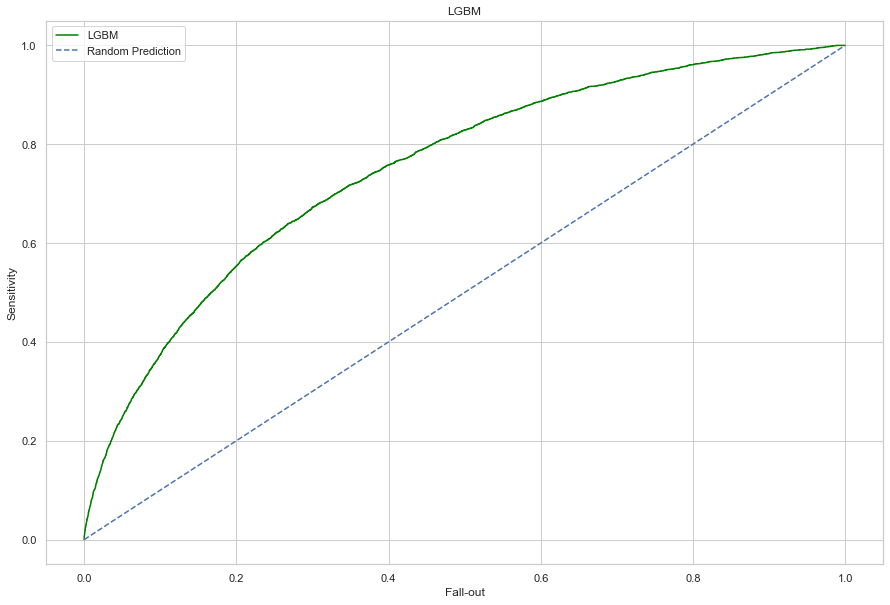

In [353]:
fallout_gbt, sensitivity_gbt, thresholds_gbt = metrics.roc_curve(y_test, preds_df["prob_defaut"])

plt.figure(figsize=(15,10))
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'LGBM')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("LGBM")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

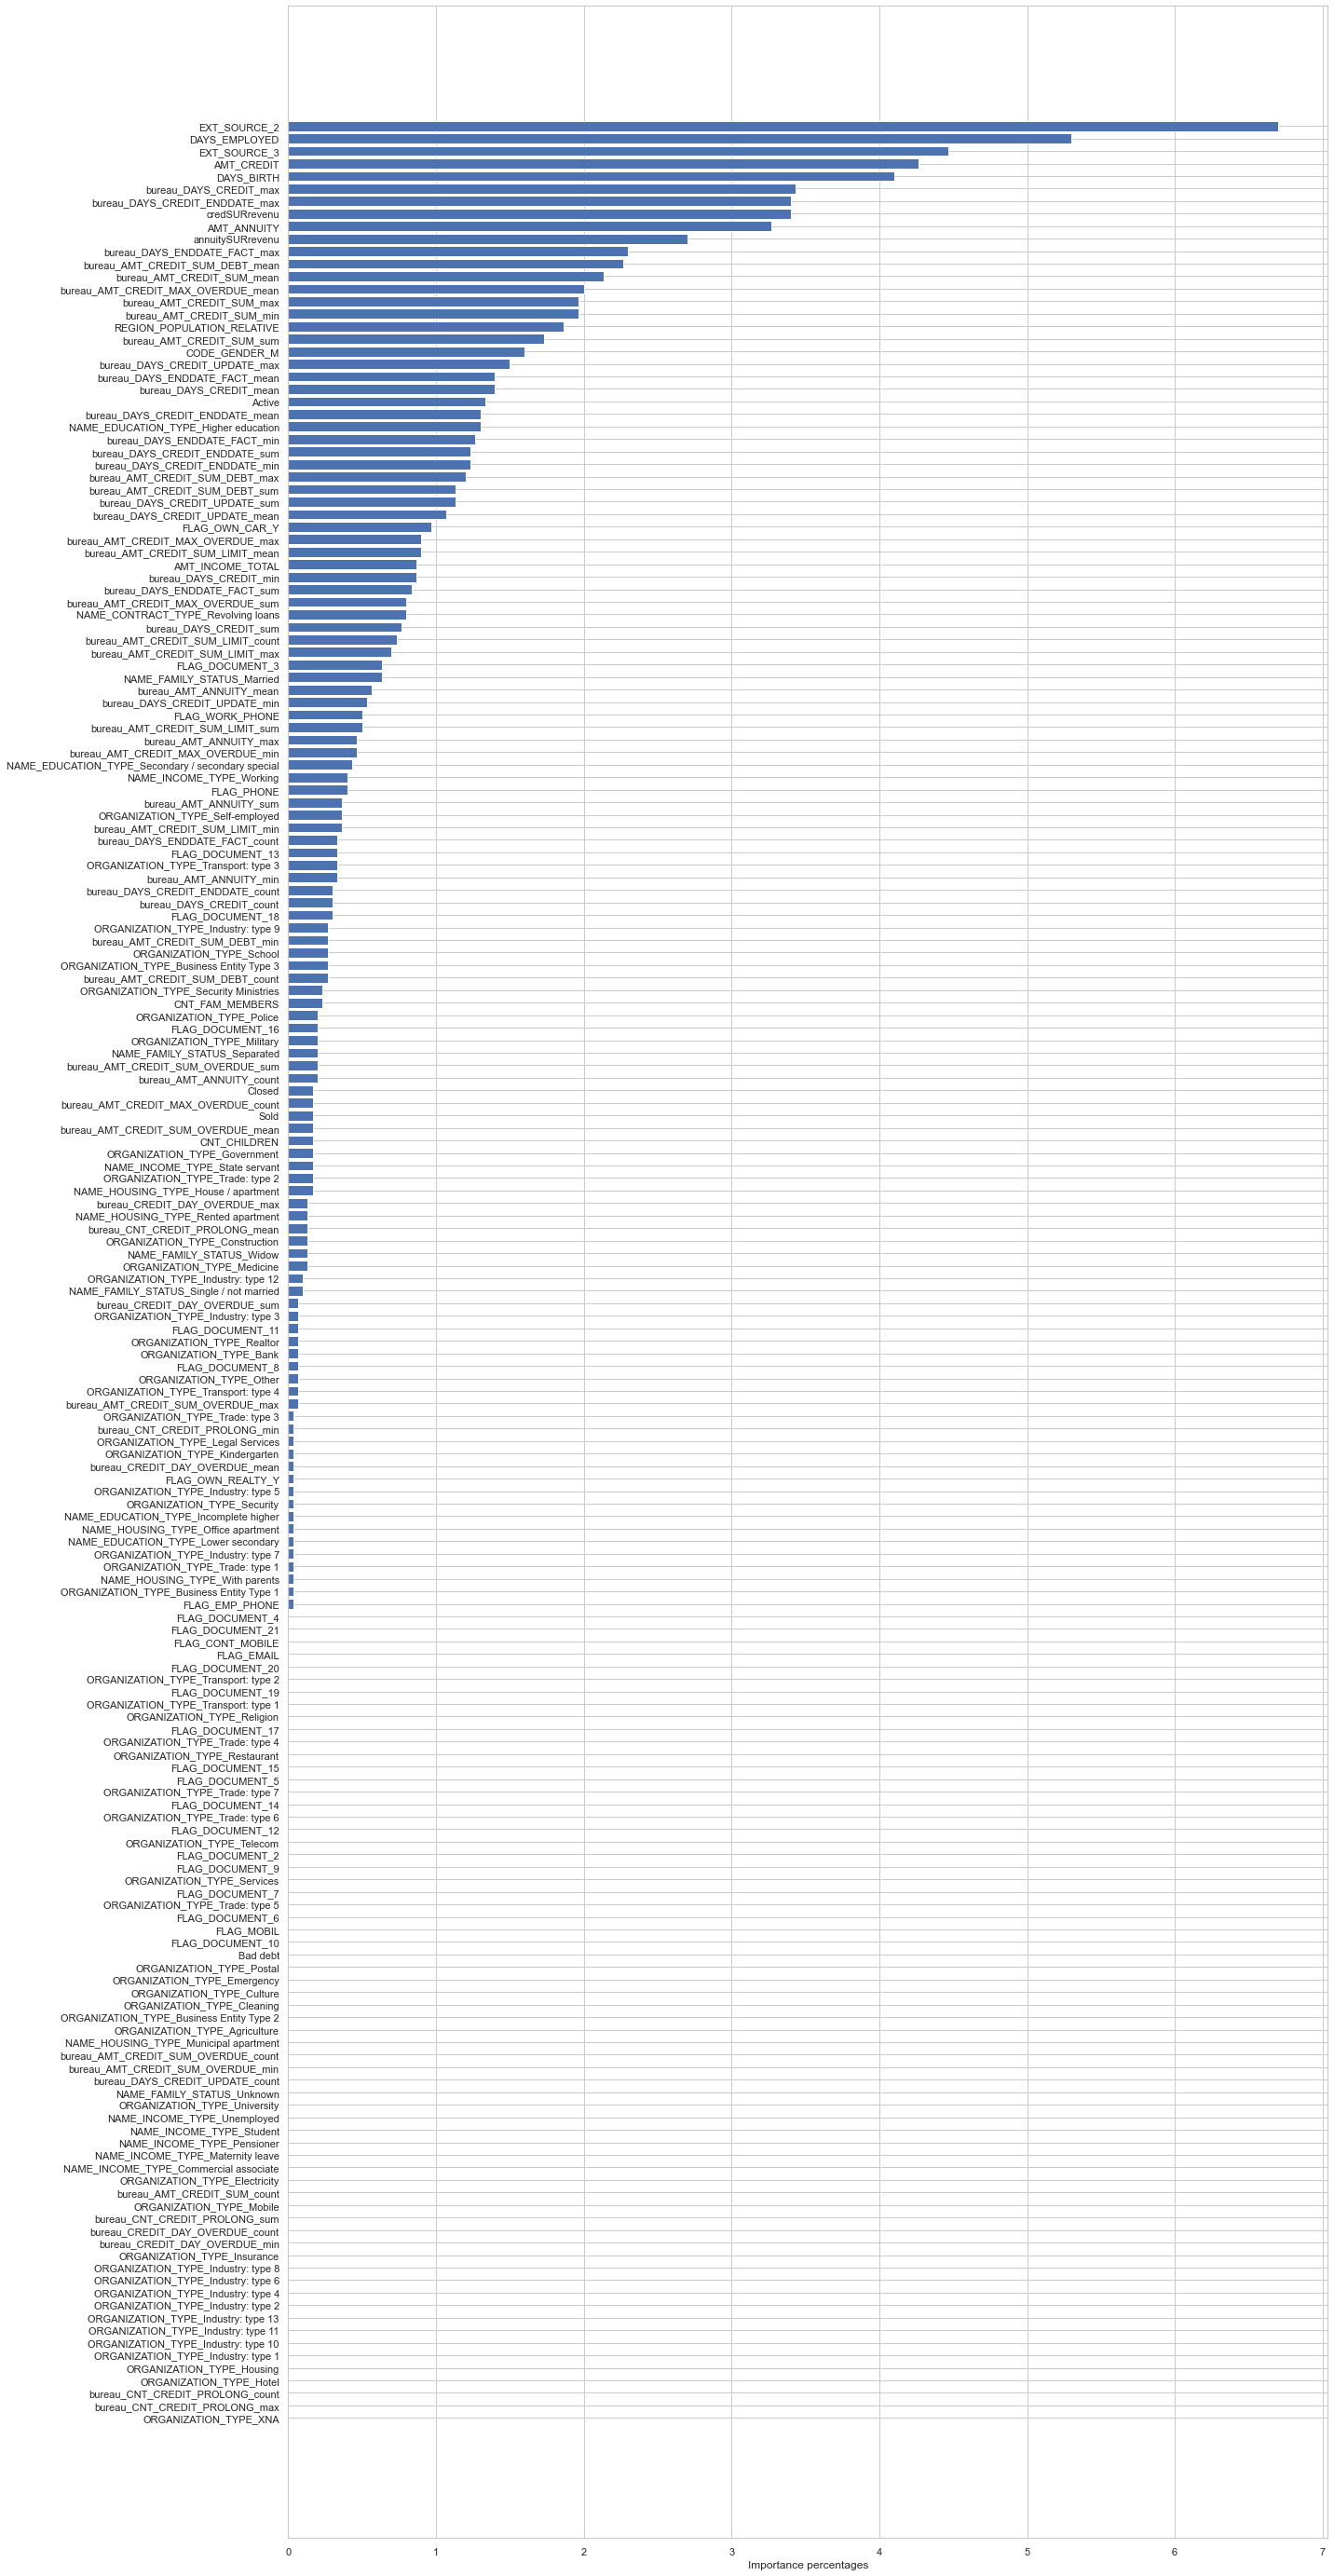

In [417]:
feature_importances = (clfL.feature_importances_/ sum(clfL.feature_importances_)) * 100

results = pd.DataFrame({'Features': X_test.columns,
                        'Importances': feature_importances})
results.sort_values(by='Importances', inplace=True)

plt.figure(figsize=(20,50))

ax = plt.barh(results['Features'], results['Importances'])
plt.xlabel('Importance percentages')
plt.show()

In [413]:
clfL.feature_importances_

array([  5,  26, 128,  98,  56, 123, 159,   0,   1,  15,   0,  12,   0,
         7, 201, 134,   0,  19,   0,   0,   0,   0,   2,   0,   0,   2,
         0,  10,   0,   0,   6,   0,   9,   0,   0,   0, 102,  81,   9,
        42, 103,  26,  23,   0,   1,   4,   0,   2,   9,  39, 102,  37,
        37,  10,  42,  69,  38,  25,   5,  60,  27,  14,  24,   0,   4,
         0,   1,   0,   0,  64,  59,  59,  52,   8,  68,  36,   8,  34,
        22,  27,  21,  11,  15,   0,   5,   2,   0,   6,   0,  32,  45,
        16,  34,   6,  17,  14,  10,  11,   5,  40,   5,   0,  24,  48,
        29,   1,   0,   0,   0,   5,   0,   0,  12,  39,   1,   1,  13,
        19,   6,   3,   0,   4,   5,   0,   1,   4,   1,   0,   2,   1,
         0,   8,   0,   4,   0,   0,   0,   5,   0,   0,   0,   0,   0,
         3,   0,   0,   2,   0,   1,   0,   1,   0,   8,   0,   1,   1,
         4,   6,   0,   2,   6,   0,   2,   0,   0,   8,   1,   7,  11,
         0,   0,   1,   5,   1,   0,   0,   0,   0,   0,   0,  1

# idéal théorique

In [354]:
thresh = [0.2, 0.225,0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5, 0.525, 0.55, 0.575, 0.6, 0.625, 0.65]

In [355]:
def_recalls = []
nondef_recalls = []
acc = []

In [356]:
for i in thresh:
    preds_df['pred_TARGET'] = preds_df['prob_defaut'].apply(lambda x: 1 if x > i else 0)
    acc.append(metrics.accuracy_score(y_test, preds_df['pred_TARGET']))
    def_recalls.append(metrics.precision_recall_fscore_support(y_test,preds_df['pred_TARGET'])[1][1])
    nondef_recalls.append(metrics.precision_recall_fscore_support(y_test,preds_df['pred_TARGET'])[1][0])

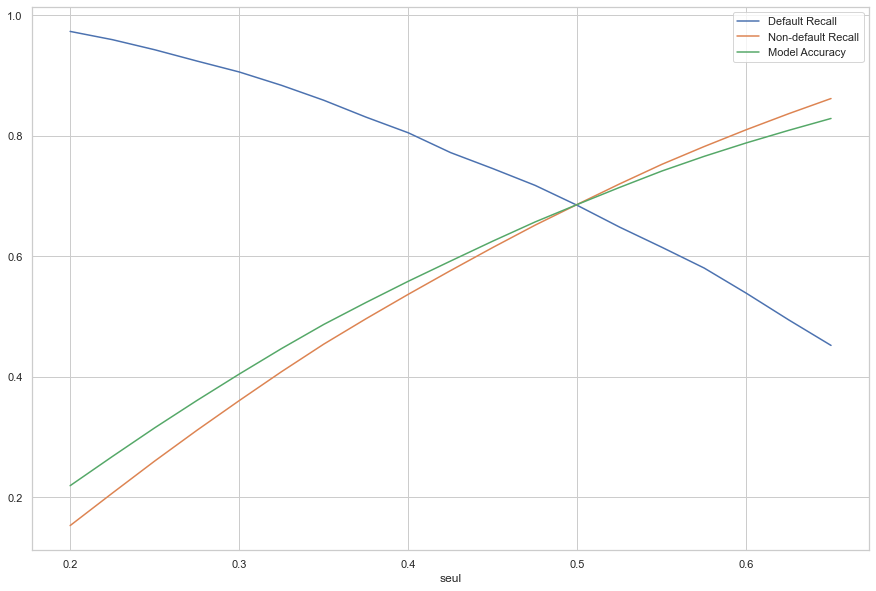

In [357]:
plt.figure(figsize=(15,10))
plt.plot(thresh, def_recalls)
plt.plot(thresh, nondef_recalls)
plt.plot(thresh, acc)
plt.xlabel("seul")
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.show()

Ici en un sens le juste milieu entre la capacité du modèle à identifier les vrais défauts, les vrais non-défauts est situé aux alentours d'un seuil de 0.5.<br>
Mais il se peut que du point de vue du métier, ce seuil soit différent.

# Théorie != pratique

Fixons un taux d'acceptation à 85%

In [358]:
threshold_85 = np.quantile(preds_df["prob_defaut"], 0.85)

# seuil d'acceptation = 0.85
preds_df['pred_TARGET'] = preds_df["prob_defaut"].apply(lambda x: 1 if x > threshold_85 else 0)

# Print the counts of loan status after the threshold
print(preds_df['pred_TARGET'].value_counts())

0    52274
1     9225
Name: pred_TARGET, dtype: int64


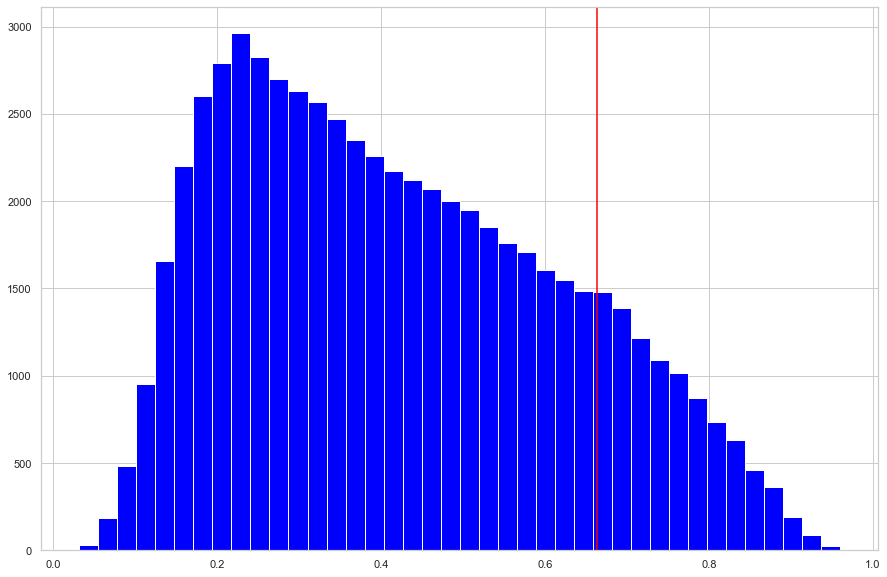

In [359]:
plt.figure(figsize=(15,10))
plt.hist(preds_df["prob_defaut"], color = 'blue', bins = 40)

plt.axvline(x = threshold_85, color = 'red')
plt.show()

In [360]:
np.sum(preds_df['TARGET'])

4965.0

In [361]:
accepted_loans = preds_df[preds_df['pred_TARGET'] == 0]

In [362]:
print(np.sum(accepted_loans['TARGET']) / accepted_loans['TARGET'].count())

0.05417607223476298


Parmi les profils acceptés avec un taux d'acceptation de 85%. Nous aurons 5% de faux négatifs

## Le coût

In [363]:
avg_loan = np.mean(preds_df['AMT_CREDIT'])

In [364]:
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(preds_df['TARGET'],
                 preds_df['pred_TARGET']).apply(lambda x: x * avg_loan, axis = 0))
pd.reset_option('^display.', silent=True)

pred_TARGET                  0                 1
TARGET                                          
$0.00       $29,631,532,942.86 $4,250,370,770.41
$1.00        $1,697,271,576.68 $1,278,347,554.05


Les prévisions de notre modèle permettent de gagner 44 milliards, les FN causent une perte de 2.6 milliards, les FP causent une perte de 6,4 milliards qui est à relativiser dans la mesure où les pertes dûes à un faux positifs relèvent davantage (d'un certain point de vue) des coûts horaires du chargé de clientèle.

# Seuil 0.5

In [365]:
threshold = np.quantile(preds_df["prob_defaut"], 0.5)

# seuil d'acceptation = 0.85
preds_df['pred_TARGET'] = preds_df["prob_defaut"].apply(lambda x: 1 if x > 0.5 else 0)

# Print the counts of loan status after the threshold
print(preds_df['pred_TARGET'].value_counts())

0    40347
1    21152
Name: pred_TARGET, dtype: int64


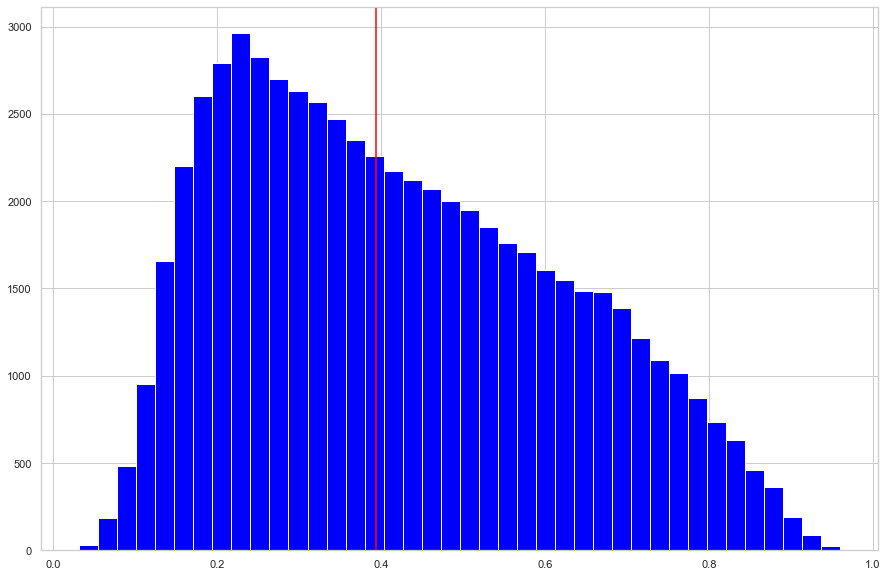

In [366]:
plt.figure(figsize=(15,10))
plt.hist(preds_df["prob_defaut"], color = 'blue', bins = 40)

plt.axvline(x = threshold, color = 'red')
plt.show()

In [367]:
accepted_loans = preds_df[preds_df['pred_TARGET'] == 0]

In [368]:
print(np.sum(accepted_loans['TARGET']) / accepted_loans['TARGET'].count())

0.038862864649168466


In [369]:
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(preds_df['TARGET'],
                 preds_df['pred_TARGET']).apply(lambda x: x * avg_loan, axis = 0))
pd.reset_option('^display.', silent=True)

pred_TARGET                  0                  1
TARGET                                           
$0.00       $23,240,993,810.75 $10,640,909,902.52
$1.00          $939,732,285.39  $2,035,886,845.33


On peut voir que le taux théorique produit des profits inférieurs à celui que nous avons fixé par hasard, soit le taux de 85%

# Recherche d'un seuil pour un profit maximal

In [370]:
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 
                0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]

Définissons différent taux d'acceptation.

In [371]:
thresholds = []
bad_rates = []
for rate in accept_rates:
    
    thresh = np.quantile(preds_df['prob_defaut'], rate).round(3)
    
    thresholds.append(np.quantile(preds_df['prob_defaut'], rate).round(3))
    
    preds_df['pred_TARGET'] = preds_df['prob_defaut'].apply(lambda x: 1 if x > thresh else 0)
    
    accepted_loans = preds_df[preds_df['pred_TARGET'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['TARGET']) / len(accepted_loans['TARGET'])).round(3))

In [372]:
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Taux acceptation','Threshold','Bad Rate'])

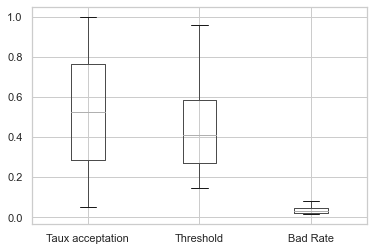

In [373]:
strat_df.boxplot()
plt.show()

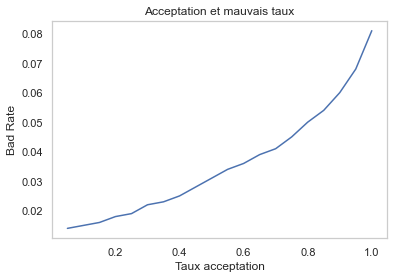

In [374]:
plt.plot(strat_df['Taux acceptation'], strat_df['Bad Rate'])
plt.xlabel('Taux acceptation')
plt.ylabel('Bad Rate')
plt.title('Acceptation et mauvais taux')
plt.axes().yaxis.grid()
plt.axes().xaxis.grid()
plt.show()

In [375]:
strat_df['Avg'] = avg_loan

In [376]:
nb_accept = []
for rate in accept_rates:
    
    thresh = np.quantile(preds_df['prob_defaut'], rate).round(3)
    
    nb_accept.append(np.sum(preds_df["prob_defaut"] < thresh))
    

In [377]:
strat_df['nb_accept'] = nb_accept

In [378]:
strat_df

,Taux acceptation,Threshold,Bad Rate,Avg,nb_accept
0,1.00,0.960,0.081,599319.059562,61498
1,0.95,0.781,0.068,599319.059562,58415
2,0.90,0.715,0.060,599319.059562,55366
3,0.85,0.663,0.054,599319.059562,52259
4,0.80,0.616,0.050,599319.059562,49190
5,0.75,0.573,0.045,599319.059562,46147
6,0.70,0.532,0.041,599319.059562,43024
7,0.65,0.495,0.039,599319.059562,39935
8,0.60,0.459,0.036,599319.059562,36870
9,0.55,0.426,0.034,599319.059562,33801


In [379]:
strat_df['estimation'] = strat_df['nb_accept']*(1-strat_df['Bad Rate'])*strat_df['Avg'] - strat_df['nb_accept']*strat_df['Bad Rate']*strat_df['Avg']

In [380]:
strat_df

,Taux acceptation,Threshold,Bad Rate,Avg,nb_accept,estimation
0,1.00,0.960,0.081,599319.059562,61498,3.088610e+10
1,0.95,0.781,0.068,599319.059562,58415,3.024797e+10
2,0.90,0.715,0.060,599319.059562,55366,2.920007e+10
3,0.85,0.663,0.054,599319.059562,52259,2.793727e+10
4,0.80,0.616,0.050,599319.059562,49190,2.653245e+10
5,0.75,0.573,0.045,599319.059562,46147,2.516767e+10
6,0.70,0.532,0.041,599319.059562,43024,2.367072e+10
7,0.65,0.495,0.039,599319.059562,39935,2.206697e+10
8,0.60,0.459,0.036,599319.059562,36870,2.050592e+10
9,0.55,0.426,0.034,599319.059562,33801,1.888007e+10


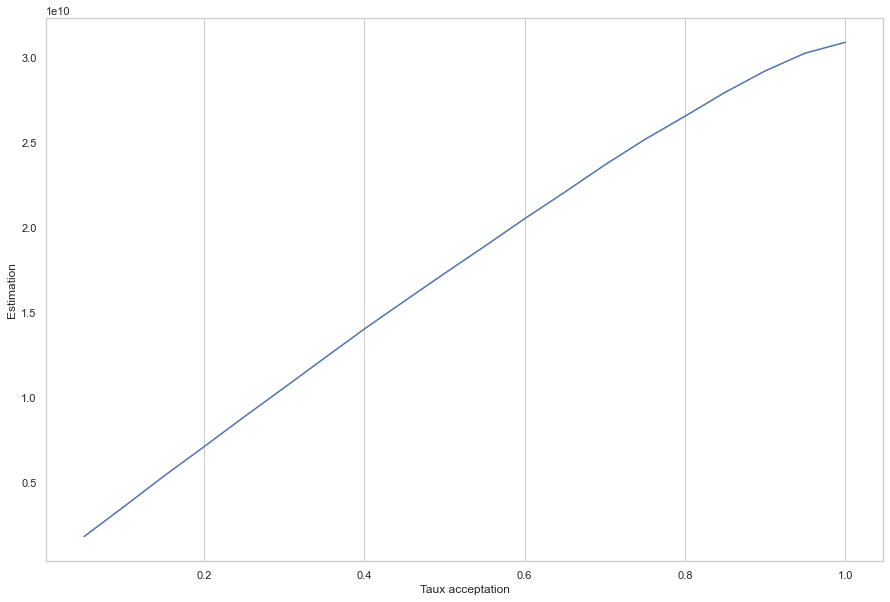

In [381]:
plt.figure(figsize=(15,10))
plt.plot(strat_df['Taux acceptation'], strat_df['estimation'])
plt.title('')
plt.xlabel('Taux acceptation')
plt.ylabel('Estimation')
plt.axes().yaxis.grid()
plt.show()

Le dataset ne contient que 8% de profil en défaut. De là, il est normal notre modélisation préconise un taux d'acceptation de 100. Dans tous les cas, nous sommes gagnons.

# Resamplons les données de test

Nous reproduisons le raisonnement précédent mais cette fois en étant moins optimiste vis à vis

In [382]:
X_y_test = pd.concat([X_test.reset_index(drop = True), y_test.reset_index(drop = True)], axis = 1)

In [383]:
X_y_test

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,...,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,TARGET
0,0,135000.0,226908.0,10705.5,0.010643,-17832,-4561.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,135000.0,314055.0,16033.5,0.031342,-15569,-8918.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,162000.0,685012.5,26932.5,0.003122,-22943,-2384.175794,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,157500.0,376920.0,18261.0,0.025162,-20785,-2384.175794,1,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,112500.0,272520.0,19957.5,0.006306,-10310,-1542.000000,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61494,1,171000.0,1473444.0,46395.0,0.019104,-10359,-345.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,0
61495,0,158400.0,348264.0,34929.0,0.022797,-14438,-1814.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,0
61496,0,157500.0,1125000.0,33025.5,0.025162,-22402,-2384.175794,1,0,0,...,0,0,0,0,0,0,0,0,1,0
61497,0,112500.0,360000.0,17640.0,0.010963,-14495,-1198.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [384]:
count_nondefault, count_default = X_y_test['TARGET'].value_counts()

In [385]:
nondefaults = X_y_test[X_y_test['TARGET'] == 0]
defaults = X_y_test[X_y_test['TARGET'] == 1]

In [386]:
nondefaults_under = nondefaults.sample(3*count_default, random_state=42)

In [387]:
X_y_test_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

In [388]:
X_test_U = X_y_test_under.drop('TARGET', axis=1)
y_test_U = X_y_test_under['TARGET']

In [389]:
preds = clfL.predict(X_test_U)

In [390]:
print(classification_report(y_test_U, preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.87      0.69      0.77     14895
     Default       0.42      0.68      0.52      4965

    accuracy                           0.69     19860
   macro avg       0.65      0.69      0.65     19860
weighted avg       0.76      0.69      0.71     19860



In [391]:
print(metrics.confusion_matrix(y_test_U, preds))

[[10255  4640]
 [ 1568  3397]]


In [392]:
preds_df = pd.DataFrame(np.array(pd.concat([pd.DataFrame(clfL.predict_proba(X_test_U))[1], pd.Series(clfL.predict(X_test_U)), y_test_U.reset_index(drop=True), X_test_U['AMT_CREDIT'].reset_index(drop=True)], axis=1)), columns=["prob_defaut", "PRED_TARGET","TARGET", "AMT_CREDIT"])

In [393]:
preds_df

,prob_defaut,PRED_TARGET,TARGET,AMT_CREDIT
0,0.606524,1.0,0.0,189621.0
1,0.276627,0.0,0.0,202500.0
2,0.562916,1.0,0.0,834048.0
3,0.208135,0.0,0.0,405000.0
4,0.502173,1.0,0.0,1724220.0
...,...,...,...,...
19855,0.398578,0.0,1.0,314055.0
19856,0.737098,1.0,1.0,582228.0
19857,0.692954,1.0,1.0,247275.0
19858,0.365138,0.0,1.0,315000.0


In [394]:
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 
                0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]

In [395]:
thresholds = []
bad_rates = []
for rate in accept_rates:
    
    thresh = np.quantile(preds_df['prob_defaut'], rate).round(3)
    
    thresholds.append(np.quantile(preds_df['prob_defaut'], rate).round(3))
    
    preds_df['pred_TARGET'] = preds_df['prob_defaut'].apply(lambda x: 1 if x > thresh else 0)
    
    accepted_loans = preds_df[preds_df['pred_TARGET'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['TARGET']) / len(accepted_loans['TARGET'])).round(3))

In [396]:
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Taux acceptation','Threshold','Bad Rate'])

In [397]:
strat_df

,Taux acceptation,Threshold,Bad Rate
0,1.00,0.960,0.250
1,0.95,0.817,0.227
2,0.90,0.758,0.209
3,0.85,0.707,0.193
4,0.80,0.665,0.180
5,0.75,0.622,0.167
6,0.70,0.581,0.153
7,0.65,0.541,0.143
8,0.60,0.504,0.133
9,0.55,0.466,0.126


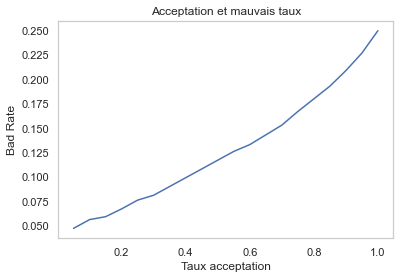

In [398]:
plt.plot(strat_df['Taux acceptation'], strat_df['Bad Rate'])
plt.xlabel('Taux acceptation')
plt.ylabel('Bad Rate')
plt.title('Acceptation et mauvais taux')
plt.axes().yaxis.grid()
plt.axes().xaxis.grid()
plt.show()

In [399]:
strat_df['Avg'] = X_test_U["AMT_CREDIT"].mean()

In [400]:
strat_df['Avg'] 

0     591335.4375
1     591335.4375
2     591335.4375
3     591335.4375
4     591335.4375
5     591335.4375
6     591335.4375
7     591335.4375
8     591335.4375
9     591335.4375
10    591335.4375
11    591335.4375
12    591335.4375
13    591335.4375
14    591335.4375
15    591335.4375
16    591335.4375
17    591335.4375
18    591335.4375
19    591335.4375
Name: Avg, dtype: float64

In [401]:
nb_accept = []
for rate in accept_rates:
    
    thresh = np.quantile(preds_df['prob_defaut'], rate).round(3)
    
    nb_accept.append(np.sum(preds_df["prob_defaut"] < thresh))

In [402]:
strat_df['nb_accept'] = nb_accept

In [403]:
strat_df

,Taux acceptation,Threshold,Bad Rate,Avg,nb_accept
0,1.00,0.960,0.250,591335.4375,19859
1,0.95,0.817,0.227,591335.4375,18863
2,0.90,0.758,0.209,591335.4375,17884
3,0.85,0.707,0.193,591335.4375,16875
4,0.80,0.665,0.180,591335.4375,15894
5,0.75,0.622,0.167,591335.4375,14905
6,0.70,0.581,0.153,591335.4375,13901
7,0.65,0.541,0.143,591335.4375,12907
8,0.60,0.504,0.133,591335.4375,11929
9,0.55,0.466,0.126,591335.4375,10913


In [404]:
strat_df['estimation'] = strat_df['nb_accept']*(1-strat_df['Bad Rate'])*strat_df['Avg'] - strat_df['nb_accept']*strat_df['Bad Rate']*strat_df['Avg']

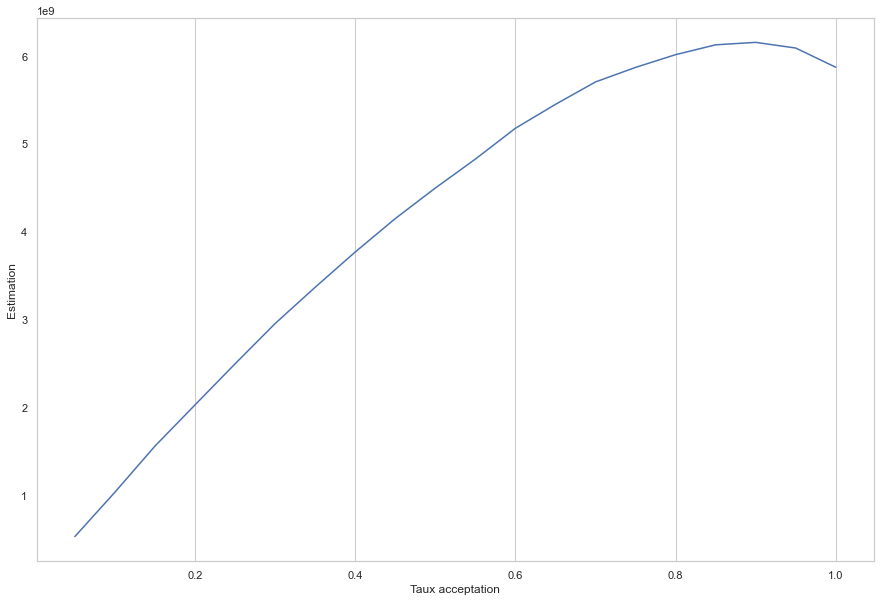

In [405]:
plt.figure(figsize=(15,10))
plt.plot(strat_df['Taux acceptation'], strat_df['estimation'])
plt.title('')
plt.xlabel('Taux acceptation')
plt.ylabel('Estimation')
plt.axes().yaxis.grid()
plt.show()

In [406]:
print(strat_df.loc[strat_df['estimation'] == np.max(strat_df['estimation'])])

   Taux acceptation  Threshold  Bad Rate          Avg  nb_accept    estimation
2               0.9      0.758     0.209  591335.4375      17884  6.154908e+09


Nous avons resamplé le dataset de sorte d'obtenir 25% de défauts dans le dataset. <br>
Dans ce cas, nous fixons le seuil de probabilité de défaut de paiement à 0.758

In [407]:
preds_df['expected_loss'] = preds_df['prob_defaut'] * preds_df['AMT_CREDIT'] 

In [408]:
tot_exp_loss = round(np.sum(preds_df['expected_loss']),2)

In [409]:
print('Le total des pertes attendues: ', '${:,.2f}'.format(tot_exp_loss))

Le total des pertes attendues:  $5,131,059,955.41


In [410]:
preds_df['pred_TARGET'] = preds_df['prob_defaut'].apply(lambda x: 1 if x > 0.752 else 0)
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(preds_df['TARGET'],
                 preds_df['pred_TARGET']).apply(lambda x: x * avg_loan, axis = 0))
pd.reset_option('^display.', silent=True)

pred_TARGET                 0               1
TARGET                                       
$0.00       $8,440,809,634.87 $486,047,757.30
$1.00       $2,202,497,543.89 $773,121,586.83
